In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import glob
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as md
import warnings
from scipy.interpolate import interp2d
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import LogNorm
from sklearn import preprocessing
import seaborn as sns
from scipy.stats import pearsonr
from scipy import stats

In [2]:
def simple_read(path):
    with open(path) as f:
        first_line = f.readline()
        header_line = int(first_line[0:-2].split(",")[0])-1
        #all_lines = f.readlines()
    data = pd.read_csv(path, sep=',', skiprows=header_line)
    data.columns = [i.strip() for i in data.columns]
    #date = all_lines[5][0:10].split(',')
    #dt = datetime(int(date[0]), int(date[1]), int(date[2]))

    acc = 0
    boo = False
    for letter in path:
        if letter == '2':
            boo = True
        elif boo and letter == '0':
            acc -= 1
            break
        acc += 1
    #print(path[:acc+4], path[acc+4:acc+6], path[acc+6:acc+8])
    dt = datetime(int(path[acc:acc+4]), int(path[acc+4:acc+6]), int(path[acc+6:acc+8]))
    
    for column in data.keys():
        if 'Time' in column:
            data[column] = dt + pd.to_timedelta(data[column], unit='seconds')
    return data.replace(-999999, np.NaN)

In [3]:
DAY2 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L1_20230614T111634.ict')
start_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 13:48:00"))
stop_index = np.where(DAY2["Time_Start"]==pd.to_datetime("2022-06-02 14:10:00"))
    
DAY2_subset = DAY2[start_index[0][0]:stop_index[0][0]]
DAY2_subset = DAY2_subset.replace(-888888, 0)
DAY2_subset


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,0.241,0.453,0.108,0.114,0.008,-0.049
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,0.241,0.453,0.108,0.114,0.008,-0.049
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,0.241,0.453,0.108,0.114,0.008,-0.049
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,0.241,0.453,0.108,0.114,0.008,-0.049
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,0.241,0.453,0.108,0.114,0.008,-0.049
...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,32.272869,-64.969777,2855.32,0.475,0.315,0.002,0.133,0.035,0.004
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,32.273564,-64.970808,2861.28,0.475,0.315,0.002,0.133,0.035,0.004
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,32.274234,-64.971861,2867.15,0.475,0.315,0.002,0.133,0.035,0.004
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,32.274877,-64.972937,2872.99,0.475,0.315,0.002,0.133,0.035,0.004


In [4]:


normal = (DAY2_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY2_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY2_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY2_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY2_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY2_subset['mz44'] = DAY2_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY2_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY2_subset.loc[:, start_col2:stop_col2] = DAY2_subset.loc[:, start_col2:stop_col2].div(normal, axis=0)
DAY2_subset['AMS'] = normal
DAY2_subset



,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
8926,2022-06-02 13:48:00,2022-06-02 13:48:01,32.397719,-65.920473,1896.68,0.260823,0.490260,0.116883,0.123377,0.008658,-0.049,-0.203320,0.924
8927,2022-06-02 13:48:01,2022-06-02 13:48:02,32.397400,-65.918900,1897.28,0.260823,0.490260,0.116883,0.123377,0.008658,-0.049,-0.203320,0.924
8928,2022-06-02 13:48:02,2022-06-02 13:48:03,32.397079,-65.917327,1898.01,0.260823,0.490260,0.116883,0.123377,0.008658,-0.049,-0.203320,0.924
8929,2022-06-02 13:48:03,2022-06-02 13:48:04,32.396758,-65.915754,1898.83,0.260823,0.490260,0.116883,0.123377,0.008658,-0.049,-0.203320,0.924
8930,2022-06-02 13:48:04,2022-06-02 13:48:05,32.396435,-65.914182,1899.75,0.260823,0.490260,0.116883,0.123377,0.008658,-0.049,-0.203320,0.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10241,2022-06-02 14:09:55,2022-06-02 14:09:56,32.272869,-64.969777,2855.32,0.494792,0.328125,0.002083,0.138542,0.036458,0.004,0.008421,0.960
10242,2022-06-02 14:09:56,2022-06-02 14:09:57,32.273564,-64.970808,2861.28,0.494792,0.328125,0.002083,0.138542,0.036458,0.004,0.008421,0.960
10243,2022-06-02 14:09:57,2022-06-02 14:09:58,32.274234,-64.971861,2867.15,0.494792,0.328125,0.002083,0.138542,0.036458,0.004,0.008421,0.960
10244,2022-06-02 14:09:58,2022-06-02 14:09:59,32.274877,-64.972937,2872.99,0.494792,0.328125,0.002083,0.138542,0.036458,0.004,0.008421,0.960


In [5]:
# Assuming you have a DataFrame named 'data' with a column named 'column_name'

# Count the number of values greater than or equal to 0.4
count = len(DAY2_subset[DAY2_subset['AMS'] >= 0.4])

# Print the count
print("Number of values >= 0.4:", count)


Number of values >= 0.4: 1320


In [6]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2_subset.GPS_Altitude_THORNHILL.min(), DAY2_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2_subset['Bins'] = pd.cut(DAY2_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2_subset_1000 = DAY2_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000 = DAY2_subset_1000[start_index:stop_index]
DAY1000_subset_1000


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(106.28, 134.006]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.208306,-65.047757,122.4800,0.207111,0.592563,0.014843,0.273041,0.002829,-0.0050,-0.009960,2.4740
"(134.006, 161.732]",2022-06-02 13:58:49.000,2022-06-02 13:58:50.000,32.202678,-64.998075,149.2400,0.098868,0.665505,0.009582,0.201655,0.024390,0.0190,0.083700,2.2960
"(161.732, 189.459]",2022-06-02 13:59:02.000,2022-06-02 13:59:03.000,32.210501,-64.983373,174.5650,0.098868,0.665505,0.009582,0.201655,0.024390,0.0190,0.083700,2.2960
"(189.459, 217.185]",2022-06-02 13:57:08.000,2022-06-02 13:57:09.000,32.233247,-65.116465,202.3350,0.184973,0.605553,0.004900,0.220090,-0.015517,0.0620,0.136865,2.4490
"(217.185, 244.911]",2022-06-02 13:57:01.500,2022-06-02 13:57:02.500,32.235899,-65.124099,231.2250,0.184973,0.605553,0.004900,0.220090,-0.015517,0.0620,0.136865,2.4490
"(244.911, 272.637]",2022-06-02 13:58:08.000,2022-06-02 13:58:09.000,32.231922,-65.051973,260.1525,0.197729,0.598495,0.000249,0.215487,-0.011960,0.0400,0.085543,2.4740
"(272.637, 300.363]",2022-06-02 13:59:28.000,2022-06-02 13:59:29.000,32.235911,-64.973962,282.5850,0.210484,0.591437,-0.004402,0.210884,-0.008403,0.0180,0.034221,2.4990
"(300.363, 328.09]",2022-06-02 13:56:41.500,2022-06-02 13:56:42.500,32.243827,-65.148157,312.9625,-0.001660,0.767553,0.010250,0.239147,-0.002588,-0.0330,0.279773,1.8710
"(328.09, 355.816]",2022-06-02 13:56:33.500,2022-06-02 13:56:34.500,32.246800,-65.158144,339.6750,-0.052179,0.775148,0.015600,0.258203,0.003228,-0.0410,0.422680,1.8590


In [7]:
# Assuming you have a DataFrame named 'data' with a column named 'column_name'

# Count the number of values greater than or equal to 0.4
count = len(DAY1000_subset_1000[DAY1000_subset_1000['AMS'] >= 0.4])

# Print the count
print("Number of values >= 0.4:", count)


Number of values >= 0.4: 31


In [8]:

#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3000

start_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000 = DAY2_subset_1000[start_index:stop_index]
DAY3000_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(993.518, 1021.245]",2022-06-02 14:02:19.500,2022-06-02 14:02:20.500,32.232227,-64.969261,1005.710,0.152929,0.612234,0.074650,0.147745,0.012442,-0.074,-0.250847,1.929
"(1021.245, 1048.971]",2022-06-02 14:02:24.500,2022-06-02 14:02:25.500,32.235766,-64.963898,1036.645,0.152929,0.612234,0.074650,0.147745,0.012442,-0.074,-0.250847,1.929
"(1048.971, 1076.697]",2022-06-02 14:02:31.500,2022-06-02 14:02:32.500,32.240709,-64.957500,1060.535,0.152929,0.612234,0.074650,0.147745,0.012442,-0.074,-0.250847,1.929
"(1076.697, 1104.423]",2022-06-02 14:02:37.500,2022-06-02 14:02:38.500,32.247281,-64.953153,1089.530,0.152929,0.612234,0.074650,0.147745,0.012442,-0.074,-0.250847,1.929
"(1104.423, 1132.149]",2022-06-02 14:02:43.000,2022-06-02 14:02:44.000,32.252841,-64.950287,1119.480,0.113208,0.693920,0.038435,0.162124,-0.007687,-0.068,-0.419753,1.431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2712.543, 2740.269]",2022-06-02 14:09:22.000,2022-06-02 14:09:23.000,32.239725,-64.957045,2729.930,0.537884,0.279070,0.043511,0.132033,0.007502,0.020,0.027894,1.333
"(2740.269, 2767.995]",2022-06-02 14:09:30.500,2022-06-02 14:09:31.500,32.249106,-64.955641,2751.515,0.537884,0.279070,0.043511,0.132033,0.007502,0.020,0.027894,1.333
"(2767.995, 2795.721]",2022-06-02 14:09:38.000,2022-06-02 14:09:39.000,32.257341,-64.957280,2784.750,0.537884,0.279070,0.043511,0.132033,0.007502,0.020,0.027894,1.333


In [9]:
DAY2b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220602_R0_L2_20230614T111634.ict')
start_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:36:00"))
stop_index = np.where(DAY2b["Time_Start"]==pd.to_datetime("2022-06-02 18:53:00"))
DAY2b_subset = DAY2b[start_index[0][0]:stop_index[0][0]]
DAY2b_subset = DAY2b_subset.replace(-888888, 0)
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,0.669,1.479,-0.051,0.057,0.028,-0.033
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,0.669,1.479,-0.051,0.057,0.028,-0.033
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,0.669,1.479,-0.051,0.057,0.028,-0.033
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,0.669,1.479,-0.051,0.057,0.028,-0.033
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,0.669,1.479,-0.051,0.057,0.028,-0.033
...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,0.836,0.176,0.024,-0.174,-0.012,0.066
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,0.836,0.176,0.024,-0.174,-0.012,0.066
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,0.836,0.176,0.024,-0.174,-0.012,0.066
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,0.836,0.176,0.024,-0.174,-0.012,0.066


In [10]:
normal2 = (DAY2b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY2b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY2b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY2b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY2b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY2b_subset['mz44'] = DAY2b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY2b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY2b_subset.loc[:, start_col2:stop_col2] = DAY2b_subset.loc[:, start_col2:stop_col2].div(normal2, axis=0)
DAY2b_subset['AMS'] = normal2
DAY2b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
9180,2022-06-02 18:36:00,2022-06-02 18:36:01,32.312301,-65.009805,191.225,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
9181,2022-06-02 18:36:01,2022-06-02 18:36:02,32.312336,-65.010962,193.480,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
9182,2022-06-02 18:36:02,2022-06-02 18:36:03,32.312332,-65.012116,195.600,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
9183,2022-06-02 18:36:03,2022-06-02 18:36:04,32.312294,-65.013268,197.010,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
9184,2022-06-02 18:36:04,2022-06-02 18:36:05,32.312221,-65.014415,197.440,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,2022-06-02 18:52:55,2022-06-02 18:52:56,32.205808,-64.977280,3678.610,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,0.078947,0.850
10196,2022-06-02 18:52:56,2022-06-02 18:52:57,32.205215,-64.976028,3684.900,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,0.078947,0.850
10197,2022-06-02 18:52:57,2022-06-02 18:52:58,32.204648,-64.974760,3691.340,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,0.078947,0.850
10198,2022-06-02 18:52:58,2022-06-02 18:52:59,32.204104,-64.973478,3697.790,0.983529,0.207059,0.028235,-0.204706,-0.014118,0.066,0.078947,0.850


In [11]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY2b_subset.GPS_Altitude_THORNHILL.min(), DAY2b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY2b_subset['Bins'] = pd.cut(DAY2b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY2b_subset_1000 = DAY2b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_1000b = DAY2b_subset_1000[start_index:stop_index]
DAY1000_subset_1000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(132.5, 168.217]",2022-06-02 18:36:33.500,2022-06-02 18:36:34.500,32.294860,-65.039923,151.3675,0.236009,0.666811,0.048156,0.024729,0.024295,0.009,0.016544,2.305
"(168.217, 203.933]",2022-06-02 18:36:12.000,2022-06-02 18:36:13.000,32.310300,-65.023333,186.7200,0.306599,0.677819,-0.023373,0.026123,0.012832,-0.033,-0.049327,2.182
"(203.933, 239.65]",2022-06-02 18:37:02.000,2022-06-02 18:37:03.000,32.265793,-65.038849,214.3750,0.127354,0.650224,0.035426,0.166816,0.020179,0.068,0.239437,2.230
"(239.65, 275.366]",2022-06-02 18:37:13.000,2022-06-02 18:37:14.000,32.254715,-65.034943,260.1500,0.127354,0.650224,0.035426,0.166816,0.020179,0.068,0.239437,2.230
"(275.366, 311.083]",2022-06-02 18:37:24.000,2022-06-02 18:37:25.000,32.245041,-65.027102,289.4500,0.127354,0.650224,0.035426,0.166816,0.020179,0.068,0.239437,2.230
"(311.083, 346.8]",2022-06-02 18:37:38.000,2022-06-02 18:37:39.000,32.237004,-65.011946,332.1600,0.031373,0.689076,0.010084,0.258263,0.011204,0.033,0.589286,1.785
"(346.8, 382.516]",2022-06-02 18:37:53.000,2022-06-02 18:37:54.000,32.236630,-64.992675,362.9050,0.031373,0.689076,0.010084,0.258263,0.011204,0.033,0.589286,1.785
"(382.516, 418.233]",2022-06-02 18:38:07.000,2022-06-02 18:38:08.000,32.244388,-64.977146,399.5450,0.151802,0.608387,0.005907,0.248080,-0.014176,0.003,0.011673,1.693
"(418.233, 453.949]",2022-06-02 18:38:19.000,2022-06-02 18:38:20.000,32.255430,-64.969121,432.9000,0.151802,0.608387,0.005907,0.248080,-0.014176,0.003,0.011673,1.693


In [12]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY2b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3000_subset_3000b = DAY2b_subset_1000[start_index:stop_index]
DAY3000_subset_3000b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(989.698, 1025.415]",2022-06-02 18:41:23.000,2022-06-02 18:41:24.000,32.269872,-64.947192,1010.300,0.312242,0.601100,-0.008941,0.085970,0.009629,0.013,0.028634,1.454
"(1025.415, 1061.132]",2022-06-02 18:41:31.500,2022-06-02 18:41:32.500,32.278880,-64.945719,1046.060,0.068655,0.590846,0.019417,0.331484,-0.010402,-0.043,-0.434343,1.442
"(1061.132, 1096.848]",2022-06-02 18:41:40.500,2022-06-02 18:41:41.500,32.288332,-64.947078,1080.155,0.068655,0.590846,0.019417,0.331484,-0.010402,-0.043,-0.434343,1.442
"(1096.848, 1132.565]",2022-06-02 18:41:52.500,2022-06-02 18:41:53.500,32.299232,-64.954250,1111.995,0.068655,0.590846,0.019417,0.331484,-0.010402,-0.043,-0.434343,1.442
"(1132.565, 1168.281]",2022-06-02 18:42:04.500,2022-06-02 18:42:05.500,32.306221,-64.966341,1150.090,0.160388,0.695371,0.039828,0.110872,-0.006459,0.035,0.234899,0.929
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3275.561, 3311.277]",2022-06-02 18:51:48.500,2022-06-02 18:51:49.500,32.275042,-65.008039,3293.650,0.323725,0.399113,-0.106430,0.325942,0.057650,-0.033,-0.226027,0.451
"(3311.277, 3346.994]",2022-06-02 18:51:54.000,2022-06-02 18:51:55.000,32.268640,-65.008712,3329.670,0.323725,0.399113,-0.106430,0.325942,0.057650,-0.033,-0.226027,0.451
"(3346.994, 3382.711]",2022-06-02 18:51:59.000,2022-06-02 18:52:00.000,32.262831,-65.009201,3366.390,0.425725,0.342391,0.012681,0.143116,0.076087,-0.021,-0.089362,0.552


In [13]:
DAY3 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220603_R0_20230614T111635.ict')
start_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 13:30:00"))
stop_index= np.where(DAY3["Time_Start"]==pd.to_datetime("2022-06-03 15:00:00"))
    
DAY3_subset = DAY3[start_index[0][0]:stop_index[0][0]]
DAY3_subset = DAY3_subset.replace(-888888, 0)
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,0.343,0.244,-0.017,0.025,-0.002,0.050
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,0.343,0.244,-0.017,0.025,-0.002,0.050
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,0.343,0.244,-0.017,0.025,-0.002,0.050
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,0.343,0.244,-0.017,0.025,-0.002,0.050
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,0.343,0.244,-0.017,0.025,-0.002,0.050
...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,0.003,0.199,0.020,0.215,0.022,-0.014
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,0.003,0.199,0.020,0.215,0.022,-0.014
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,0.003,0.199,0.020,0.215,0.022,-0.014
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,0.003,0.199,0.020,0.215,0.022,-0.014


In [14]:
normal3 = (DAY3_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY3_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY3_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY3_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY3_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY3_subset['mz44'] = DAY3_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY3_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY3_subset.loc[:, start_col2:stop_col2] = DAY3_subset.loc[:, start_col2:stop_col2].div(normal3, axis=0)
DAY3_subset['AMS'] = normal3
DAY3_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
2467,2022-06-03 13:30:00,2022-06-03 13:30:01,33.872982,-67.052387,2858.90,0.578415,0.411467,-0.028668,0.042159,-0.003373,0.050,0.145773,0.593
2468,2022-06-03 13:30:01,2022-06-03 13:30:02,33.872534,-67.053832,2861.55,0.578415,0.411467,-0.028668,0.042159,-0.003373,0.050,0.145773,0.593
2469,2022-06-03 13:30:02,2022-06-03 13:30:03,33.872086,-67.055272,2863.82,0.578415,0.411467,-0.028668,0.042159,-0.003373,0.050,0.145773,0.593
2470,2022-06-03 13:30:03,2022-06-03 13:30:04,33.871638,-67.056704,2865.57,0.578415,0.411467,-0.028668,0.042159,-0.003373,0.050,0.145773,0.593
2471,2022-06-03 13:30:04,2022-06-03 13:30:05,33.871187,-67.058127,2866.59,0.578415,0.411467,-0.028668,0.042159,-0.003373,0.050,0.145773,0.593
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7862,2022-06-03 14:59:55,2022-06-03 14:59:56,32.712767,-65.244314,2413.61,0.006536,0.433551,0.043573,0.468410,0.047930,-0.014,-4.666667,0.459
7863,2022-06-03 14:59:56,2022-06-03 14:59:57,32.712103,-65.243151,2408.15,0.006536,0.433551,0.043573,0.468410,0.047930,-0.014,-4.666667,0.459
7864,2022-06-03 14:59:57,2022-06-03 14:59:58,32.711441,-65.241989,2402.02,0.006536,0.433551,0.043573,0.468410,0.047930,-0.014,-4.666667,0.459
7865,2022-06-03 14:59:58,2022-06-03 14:59:59,32.710779,-65.240827,2395.43,0.006536,0.433551,0.043573,0.468410,0.047930,-0.014,-4.666667,0.459


In [15]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY3_subset.GPS_Altitude_THORNHILL.min(), DAY3_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY3_subset['Bins'] = pd.cut(DAY3_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY3_subset_1000 = DAY3_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_3 = DAY3_subset_1000[start_index:stop_index]
DAY1000_subset_3


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(94.825, 149.89]",2022-06-03 13:45:28.500,2022-06-03 13:45:29.500,34.142639,-67.165956,122.9500,0.225806,0.619718,0.004320,0.161141,-0.000799,0.0320,0.059278,2.315
"(149.89, 204.956]",2022-06-03 13:54:59.500,2022-06-03 13:55:00.500,33.928738,-67.590937,187.3925,0.289773,0.546167,0.040505,0.165891,0.011742,0.0600,0.099278,2.363
"(204.956, 260.021]",2022-06-03 14:00:22.500,2022-06-03 14:00:23.500,34.111793,-67.404486,247.7050,0.197851,0.632220,0.018510,0.176174,0.001552,0.0130,0.028103,2.368
"(260.021, 315.086]",2022-06-03 13:56:57.000,2022-06-03 13:56:58.000,33.959246,-67.563614,275.4400,0.245036,0.641690,0.017599,0.136048,0.001388,0.0400,0.071429,2.161
"(315.086, 370.151]",2022-06-03 13:55:36.500,2022-06-03 13:55:37.500,33.976991,-67.341925,339.8950,0.152252,0.647715,-0.006002,0.215225,0.002790,0.0245,0.056423,2.166
"(370.151, 425.217]",2022-06-03 14:04:58.500,2022-06-03 14:04:59.500,34.251154,-67.066855,406.7575,0.152252,0.641690,0.003066,0.209108,-0.004292,0.0510,0.267016,2.152
"(425.217, 480.282]",2022-06-03 14:05:23.500,2022-06-03 14:05:24.500,34.249331,-67.072107,456.6750,-0.064378,0.952790,0.003066,0.112814,-0.004292,-0.1010,0.961905,1.631
"(480.282, 535.347]",2022-06-03 14:10:05.000,2022-06-03 14:10:06.000,34.179626,-67.299747,499.2650,0.150360,0.664972,0.008750,0.154417,0.010937,0.0460,0.118261,2.694
"(535.347, 590.412]",2022-06-03 14:14:56.000,2022-06-03 14:14:57.000,33.993495,-67.622091,562.7650,-0.013814,0.768227,0.029931,0.194167,0.021489,0.0350,-1.944444,1.303


In [16]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY3_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY3_subset_3000 = DAY3_subset_1000[start_index:stop_index]
DAY3_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(975.869, 1030.934]",2022-06-03 14:16:33.500,2022-06-03 14:16:34.500,33.965128,-67.706089,1003.240,0.211718,0.668269,0.000621,0.138509,0.002484,-0.0070,-0.023891,1.2480
"(1030.934, 1086.0]",2022-06-03 14:16:45.000,2022-06-03 14:16:46.000,33.975829,-67.718794,1059.470,0.171763,0.668269,-0.018429,0.223558,0.003597,-0.0170,-0.119718,1.2480
"(1086.0, 1141.065]",2022-06-03 14:16:31.500,2022-06-03 14:16:32.500,33.988404,-67.726647,1108.940,0.171763,0.582126,-0.018429,0.223558,0.003597,-0.0170,-0.119718,1.2480
"(1141.065, 1196.13]",2022-06-03 13:33:26.500,2022-06-03 13:33:27.500,33.858219,-67.077414,1171.680,0.171763,0.517986,0.022482,0.284173,0.003597,-0.0430,-0.225131,1.1120
"(1196.13, 1251.195]",2022-06-03 14:25:41.000,2022-06-03 14:25:42.000,34.283454,-67.038518,1211.990,0.423913,0.582126,-0.060386,0.077295,-0.022947,-0.1000,-0.284900,0.8280
"(1251.195, 1306.26]",2022-06-03 13:33:12.000,2022-06-03 13:33:13.000,33.862823,-67.056964,1279.990,0.281407,0.517986,-0.029313,0.274707,-0.001675,-0.0430,-0.225131,1.1120
"(1306.26, 1361.326]",2022-06-03 13:59:32.500,2022-06-03 13:59:33.500,34.076123,-67.027614,1337.770,0.224105,0.447791,-0.052044,0.384272,-0.004124,-0.0265,-0.126642,1.2055
"(1361.326, 1416.391]",2022-06-03 14:26:11.500,2022-06-03 14:26:12.500,34.301374,-67.000262,1382.065,0.166804,0.420707,-0.074774,0.493837,-0.006574,-0.0490,-0.241379,1.2170
"(1416.391, 1471.456]",2022-06-03 13:32:49.000,2022-06-03 13:32:50.000,33.856856,-67.027029,1443.090,0.281407,0.474874,-0.029313,0.274707,-0.001675,-0.0040,-0.011905,1.1940


In [17]:
DAY7 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220607_R0_L1_20230614T111635.ict')
start_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:32:00"))
stop_index = np.where(DAY7["Time_Start"]==pd.to_datetime("2022-06-07 14:47:00"))
    
DAY7_subset =DAY7[start_index[0][0]:stop_index[0][0]]
DAY7_subset = DAY7_subset.replace(-888888, 0)
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,1.99,0.94,0.086,0.069,0.008,0.245
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,1.99,0.94,0.086,0.069,0.008,0.245
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,1.99,0.94,0.086,0.069,0.008,0.245
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,1.99,0.94,0.086,0.069,0.008,0.245
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,1.99,0.94,0.086,0.069,0.008,0.245
...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,0.46,0.33,0.027,-0.270,-0.026,0.072
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,0.46,0.33,0.027,-0.270,-0.026,0.072
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,0.46,0.33,0.027,-0.270,-0.026,0.072
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,0.46,0.33,0.027,-0.270,-0.026,0.072


In [18]:
normal7 = (DAY7_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY7_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY7_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY7_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY7_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY7_subset['mz44'] = DAY7_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY7_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY7_subset.loc[:, start_col2:stop_col2] = DAY7_subset.loc[:, start_col2:stop_col2].div(normal7, axis=0)
DAY7_subset['AMS'] = normal7
DAY7_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10397,2022-06-07 14:32:00,2022-06-07 14:32:01,32.250498,-64.999220,127.595,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
10398,2022-06-07 14:32:01,2022-06-07 14:32:02,32.249883,-64.998233,126.585,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
10399,2022-06-07 14:32:02,2022-06-07 14:32:03,32.249267,-64.997244,125.870,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
10400,2022-06-07 14:32:03,2022-06-07 14:32:04,32.248648,-64.996254,125.955,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
10401,2022-06-07 14:32:04,2022-06-07 14:32:05,32.248027,-64.995263,126.990,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11292,2022-06-07 14:46:55,2022-06-07 14:46:56,32.255021,-64.999573,2800.660,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,0.156522,0.521
11293,2022-06-07 14:46:56,2022-06-07 14:46:57,32.255098,-64.998248,2805.770,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,0.156522,0.521
11294,2022-06-07 14:46:57,2022-06-07 14:46:58,32.255152,-64.996919,2810.920,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,0.156522,0.521
11295,2022-06-07 14:46:58,2022-06-07 14:46:59,32.255184,-64.995588,2816.140,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,0.156522,0.521


In [19]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7_subset.GPS_Altitude_THORNHILL.min(), DAY7_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7_subset['Bins'] = pd.cut(DAY7_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7_subset_1000 = DAY7_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7 = DAY7_subset_1000[start_index:stop_index]
DAY1000_subset_7


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(125.87, 152.826]",2022-06-07 14:32:05.500,2022-06-07 14:32:06.500,32.247084,-64.993783,130.6300,0.643388,0.303912,0.027805,0.022308,0.002586,0.245,0.123116,3.093
"(152.826, 179.781]",2022-06-07 14:32:14.000,2022-06-07 14:32:15.000,32.241242,-64.985855,172.0250,0.608696,0.276398,0.022516,0.087474,0.004917,0.372,0.158163,3.864
"(179.781, 206.737]",2022-06-07 14:32:27.500,2022-06-07 14:32:28.500,32.229405,-64.976252,188.3900,0.608696,0.276398,0.022516,0.087474,0.004917,0.372,0.158163,3.864
"(206.737, 233.692]",2022-06-07 14:32:40.000,2022-06-07 14:32:41.000,32.216014,-64.972467,219.6400,0.541940,0.231022,0.020853,0.195408,0.010778,0.296,0.127972,4.268
"(233.692, 260.648]",2022-06-07 14:32:48.000,2022-06-07 14:32:49.000,32.207231,-64.973025,250.9800,0.541940,0.231022,0.020853,0.195408,0.010778,0.296,0.127972,4.268
"(260.648, 287.604]",2022-06-07 14:33:01.000,2022-06-07 14:33:02.000,32.193921,-64.978990,261.7850,0.541940,0.231022,0.020853,0.195408,0.010778,0.296,0.127972,4.268
"(287.604, 314.559]",2022-06-07 14:33:13.500,2022-06-07 14:33:14.500,32.184462,-64.990490,305.6750,0.549837,0.264625,0.015566,0.165704,0.004268,0.284,0.129680,3.983
"(314.559, 341.515]",2022-06-07 14:33:26.000,2022-06-07 14:33:27.000,32.179369,-65.005060,326.2850,0.549837,0.264625,0.015566,0.165704,0.004268,0.284,0.129680,3.983
"(341.515, 368.47]",2022-06-07 14:33:38.000,2022-06-07 14:33:39.000,32.179429,-65.019922,353.5650,0.565186,0.260015,0.014567,0.151493,0.008740,0.286,0.122852,4.119


In [20]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7_subset_3000 = DAY7_subset_1000[start_index:stop_index]
DAY7_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1015.405, 1042.36]",2022-06-07 14:38:12.000,2022-06-07 14:38:13.000,32.229355,-65.062216,1030.120,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143,0.107681,3.074
"(1042.36, 1069.316]",2022-06-07 14:38:21.000,2022-06-07 14:38:22.000,32.237006,-65.057784,1055.940,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143,0.107681,3.074
"(1069.316, 1096.272]",2022-06-07 14:38:32.000,2022-06-07 14:38:33.000,32.245194,-65.050061,1084.140,0.432010,0.395250,0.023097,0.150943,-0.001301,0.143,0.107681,3.074
"(1096.272, 1123.227]",2022-06-07 14:38:42.500,2022-06-07 14:38:43.500,32.251219,-65.040481,1107.855,0.351597,0.424546,0.015654,0.195679,0.012523,0.132,0.117542,3.194
"(1123.227, 1150.183]",2022-06-07 14:38:52.000,2022-06-07 14:38:53.000,32.254166,-65.030077,1136.620,0.351597,0.424546,0.015654,0.195679,0.012523,0.132,0.117542,3.194
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(2659.696, 2686.652]",2022-06-07 14:46:31.000,2022-06-07 14:46:32.000,32.246810,-65.029401,2672.740,0.889796,0.273469,-0.104762,0.005442,-0.063946,0.079,0.120795,0.735
"(2686.652, 2713.608]",2022-06-07 14:46:36.000,2022-06-07 14:46:37.000,32.249493,-65.023658,2699.640,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,0.156522,0.521
"(2713.608, 2740.563]",2022-06-07 14:46:41.000,2022-06-07 14:46:42.000,32.251676,-65.017607,2726.120,0.882917,0.633397,0.051823,-0.518234,-0.049904,0.072,0.156522,0.521


In [21]:
DAY7b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220607_R0_L2_20230614T111635.ict')
start_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:08:00"))
stop_index = np.where(DAY7b["Time_Start"]==pd.to_datetime("2022-06-07 19:23:00"))
    
DAY7b_subset = DAY7b[start_index[0][0]:stop_index[0][0]]
DAY7b_subset = DAY7b_subset.replace(-888888, 0)
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,0.875,0.562,0.050,0.120,0.004,0.077
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,0.875,0.562,0.050,0.120,0.004,0.077
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,0.875,0.562,0.050,0.120,0.004,0.077
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,0.875,0.562,0.050,0.120,0.004,0.077
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,0.875,0.562,0.050,0.120,0.004,0.077
...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,0.538,0.199,0.045,0.271,0.004,0.148
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,0.538,0.199,0.045,0.271,0.004,0.148
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,0.538,0.199,0.045,0.271,0.004,0.148
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,0.538,0.199,0.045,0.271,0.004,0.148


In [22]:
normal7b = (DAY7b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY7b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY7b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY7b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY7b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY7b_subset['mz44'] = DAY7b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY7b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY7b_subset.loc[:, start_col2:stop_col2] = DAY7b_subset.loc[:, start_col2:stop_col2].div(normal7b, axis=0)
DAY7b_subset['AMS'] = normal7b
DAY7b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10420,2022-06-07 19:08:00,2022-06-07 19:08:01,32.242823,-65.003952,133.320,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
10421,2022-06-07 19:08:01,2022-06-07 19:08:02,32.243085,-65.002775,133.120,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
10422,2022-06-07 19:08:02,2022-06-07 19:08:03,32.243347,-65.001596,132.930,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
10423,2022-06-07 19:08:03,2022-06-07 19:08:04,32.243610,-65.000416,132.720,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
10424,2022-06-07 19:08:04,2022-06-07 19:08:05,32.243873,-64.999235,132.595,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11315,2022-06-07 19:22:55,2022-06-07 19:22:56,32.296480,-65.011792,3518.030,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,0.275093,1.057
11316,2022-06-07 19:22:56,2022-06-07 19:22:57,32.296519,-65.013093,3524.890,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,0.275093,1.057
11317,2022-06-07 19:22:57,2022-06-07 19:22:58,32.296518,-65.014396,3531.840,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,0.275093,1.057
11318,2022-06-07 19:22:58,2022-06-07 19:22:59,32.296479,-65.015699,3538.850,0.508988,0.188269,0.042573,0.256386,0.003784,0.148,0.275093,1.057


In [23]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY7b_subset.GPS_Altitude_THORNHILL.min(), DAY7b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY7b_subset['Bins'] = pd.cut(DAY7b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY7b_subset_1000 = DAY7b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_7b = DAY7b_subset_1000[start_index:stop_index]
DAY1000_subset_7b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(132.595, 166.728]",2022-06-07 19:08:09.000,2022-06-07 19:08:10.000,32.245348,-64.993377,138.9650,0.543141,0.348852,0.031037,0.074488,0.002483,0.077,0.088000,1.611
"(166.728, 200.861]",2022-06-07 19:08:21.500,2022-06-07 19:08:22.500,32.252398,-64.980762,183.5400,0.565343,0.328728,0.078296,0.033391,-0.005757,0.077,0.078411,1.737
"(200.861, 234.994]",2022-06-07 19:08:31.500,2022-06-07 19:08:32.500,32.261138,-64.974323,217.5125,0.565343,0.328728,0.078296,0.033391,-0.005757,0.077,0.078411,1.737
"(234.994, 269.127]",2022-06-07 19:08:42.500,2022-06-07 19:08:43.500,32.272447,-64.972235,251.5325,0.565343,0.328728,0.078296,0.033391,-0.005757,0.077,0.078411,1.737
"(269.127, 303.26]",2022-06-07 19:08:51.500,2022-06-07 19:08:52.500,32.281722,-64.974383,286.8050,0.496990,0.300334,0.011371,0.161873,0.029431,0.066,0.088829,1.495
"(303.26, 337.393]",2022-06-07 19:09:01.500,2022-06-07 19:09:02.500,32.290928,-64.980598,318.2300,0.496990,0.300334,0.011371,0.161873,0.029431,0.066,0.088829,1.495
"(337.393, 371.526]",2022-06-07 19:09:12.000,2022-06-07 19:09:13.000,32.298341,-64.990692,354.8600,0.496990,0.300334,0.011371,0.161873,0.029431,0.066,0.088829,1.495
"(371.526, 405.659]",2022-06-07 19:09:23.500,2022-06-07 19:09:24.500,32.302729,-65.004544,389.4000,0.588634,0.263816,0.006778,0.144943,-0.004171,0.141,0.124889,1.918
"(405.659, 439.792]",2022-06-07 19:09:35.000,2022-06-07 19:09:36.000,32.302622,-65.019577,421.5550,0.588634,0.263816,0.006778,0.144943,-0.004171,0.141,0.124889,1.918


In [24]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY7b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY7b_subset_3000 = DAY7b_subset_1000[start_index:stop_index]
DAY7b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(985.921, 1020.054]",2022-06-07 19:12:28.500,2022-06-07 19:12:29.500,32.296267,-64.998305,1003.240,0.563830,0.428369,0.017021,-0.006383,-0.002837,0.184,0.115723,2.820
"(1020.054, 1054.187]",2022-06-07 19:12:38.500,2022-06-07 19:12:39.500,32.300110,-65.010330,1036.910,0.563830,0.428369,0.017021,-0.006383,-0.002837,0.184,0.115723,2.820
"(1054.187, 1088.32]",2022-06-07 19:12:48.000,2022-06-07 19:12:49.000,32.300666,-65.022512,1072.330,0.456305,0.379765,0.024927,0.134897,0.004106,0.239,0.153599,3.410
"(1088.32, 1122.453]",2022-06-07 19:12:58.500,2022-06-07 19:12:59.500,32.297754,-65.035518,1104.765,0.456305,0.379765,0.024927,0.134897,0.004106,0.239,0.153599,3.410
"(1122.453, 1156.586]",2022-06-07 19:13:10.500,2022-06-07 19:13:11.500,32.290292,-65.048118,1140.005,0.456305,0.379765,0.024927,0.134897,0.004106,0.239,0.153599,3.410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3306.969, 3341.102]",2022-06-07 19:22:24.000,2022-06-07 19:22:25.000,32.278740,-64.979743,3325.470,0.365105,0.158320,-0.059774,0.537964,-0.001616,0.000,0.000000,0.619
"(3341.102, 3375.235]",2022-06-07 19:22:29.500,2022-06-07 19:22:30.500,32.283576,-64.983815,3359.530,0.365105,0.158320,-0.059774,0.537964,-0.001616,0.000,0.000000,0.619
"(3375.235, 3409.368]",2022-06-07 19:22:35.000,2022-06-07 19:22:36.000,32.287903,-64.988645,3393.950,0.365105,0.158320,-0.059774,0.537964,-0.001616,0.000,0.000000,0.619


In [25]:
DAY8 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220608_R0_L2_20230614T111636.ict')
start_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:30:00"))
stop_index = np.where(DAY8["Time_Start"]==pd.to_datetime("2022-06-08 20:45:00"))
    
DAY8_subset = DAY8[start_index[0][0]:stop_index[0][0]]
DAY8_subset = DAY8_subset.replace(-888888, 0)
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,1.050,1.150,0.088,0.330,0.037,0.169
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,1.050,1.150,0.088,0.330,0.037,0.169
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,1.050,1.150,0.088,0.330,0.037,0.169
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,1.050,1.150,0.088,0.330,0.037,0.169
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,1.050,1.150,0.088,0.330,0.037,0.169
...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,0.153,0.308,0.063,0.185,-0.003,0.050
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,0.153,0.308,0.063,0.185,-0.003,0.050
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,0.153,0.308,0.063,0.185,-0.003,0.050
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,0.153,0.308,0.063,0.185,-0.003,0.050


In [26]:
normal8 = (DAY8_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY8_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY8_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY8_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY8_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY8_subset['mz44'] = DAY8_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY8_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY8_subset.loc[:, start_col2:stop_col2] = DAY8_subset.loc[:, start_col2:stop_col2].div(normal8, axis=0)
DAY8_subset['AMS'] = normal8
DAY8_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10668,2022-06-08 20:30:00,2022-06-08 20:30:01,32.267080,-64.998961,152.725,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.160952,2.655
10669,2022-06-08 20:30:01,2022-06-08 20:30:02,32.268158,-64.999178,153.350,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.160952,2.655
10670,2022-06-08 20:30:02,2022-06-08 20:30:03,32.269234,-64.999434,153.870,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.160952,2.655
10671,2022-06-08 20:30:03,2022-06-08 20:30:04,32.270310,-64.999724,154.255,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.160952,2.655
10672,2022-06-08 20:30:04,2022-06-08 20:30:05,32.271382,-65.000051,154.510,0.395480,0.433145,0.033145,0.124294,0.013936,0.169,0.160952,2.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11563,2022-06-08 20:44:55,2022-06-08 20:44:56,32.251172,-65.086081,3838.620,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,0.326797,0.706
11564,2022-06-08 20:44:56,2022-06-08 20:44:57,32.250122,-65.085465,3847.170,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,0.326797,0.706
11565,2022-06-08 20:44:57,2022-06-08 20:44:58,32.249088,-65.084808,3855.660,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,0.326797,0.706
11566,2022-06-08 20:44:58,2022-06-08 20:44:59,32.248074,-65.084107,3864.100,0.216714,0.436261,0.089235,0.262040,-0.004249,0.050,0.326797,0.706


In [27]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY8_subset.GPS_Altitude_THORNHILL.min(), DAY8_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY8_subset['Bins'] = pd.cut(DAY8_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY8_subset_1000 = DAY8_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_8 = DAY8_subset_1000[start_index:stop_index]
DAY1000_subset_8


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(147.455, 184.705]",2022-06-08 20:30:28.000,2022-06-08 20:30:29.000,32.293626,-65.017848,154.5400,0.434934,0.473664,0.014717,0.073199,0.003486,0.142,0.126447,2.582
"(184.705, 221.955]",2022-06-08 20:31:07.000,2022-06-08 20:31:08.000,32.300051,-65.066294,198.9850,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102,0.114094,2.172
"(221.955, 259.205]",2022-06-08 20:31:21.500,2022-06-08 20:31:22.500,32.291698,-65.080461,242.1600,0.411602,0.590239,0.000460,0.001381,-0.003683,0.102,0.114094,2.172
"(259.205, 296.455]",2022-06-08 20:31:32.500,2022-06-08 20:31:33.500,32.282742,-65.087275,278.0025,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.084257,2.093
"(296.455, 333.705]",2022-06-08 20:31:44.000,2022-06-08 20:31:45.000,32.272093,-65.089858,314.4600,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.084257,2.093
"(333.705, 370.955]",2022-06-08 20:31:54.500,2022-06-08 20:31:55.500,32.262326,-65.088323,352.5375,0.430960,0.639274,0.017678,-0.087434,-0.000478,0.076,0.084257,2.093
"(370.955, 408.205]",2022-06-08 20:32:04.500,2022-06-08 20:32:05.500,32.253920,-65.083280,389.1225,0.367757,0.641121,0.014019,-0.008879,-0.014019,0.124,0.157560,2.140
"(408.205, 445.455]",2022-06-08 20:32:15.500,2022-06-08 20:32:16.500,32.246596,-65.074434,425.9075,0.367757,0.641121,0.014019,-0.008879,-0.014019,0.124,0.157560,2.140
"(445.455, 482.705]",2022-06-08 20:32:27.000,2022-06-08 20:32:28.000,32.241922,-65.062468,462.3600,0.216404,0.651993,0.027340,0.103336,0.000927,0.095,0.203426,2.158


In [28]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY8_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY8_subset_3000 = DAY8_subset_1000[start_index:stop_index]
DAY8_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1004.206, 1041.456]",2022-06-08 20:35:22.000,2022-06-08 20:35:23.000,32.281187,-65.081965,1020.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(1041.456, 1078.706]",2022-06-08 20:35:35.000,2022-06-08 20:35:36.000,32.268765,-65.078655,1060.190,0.391133,0.475858,0.009414,0.104160,0.019435,0.161,0.125000,3.293
"(1078.706, 1115.956]",2022-06-08 20:35:48.500,2022-06-08 20:35:49.500,32.257159,-65.071069,1096.685,0.391133,0.475858,0.009414,0.104160,0.019435,0.161,0.125000,3.293
"(1115.956, 1153.206]",2022-06-08 20:36:00.500,2022-06-08 20:36:01.500,32.249873,-65.060165,1134.755,0.391962,0.508416,0.009275,0.092065,-0.001718,0.120,0.105171,2.911
"(1153.206, 1190.456]",2022-06-08 20:36:12.500,2022-06-08 20:36:13.500,32.247776,-65.046364,1173.080,0.391962,0.508416,0.009275,0.092065,-0.001718,0.120,0.105171,2.911
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3276.459, 3313.709]",2022-06-08 20:43:51.000,2022-06-08 20:43:52.000,32.296100,-65.043959,3293.800,0.285347,0.650386,-0.074550,0.105398,0.033419,0.028,0.252252,0.389
"(3313.709, 3350.959]",2022-06-08 20:43:55.500,2022-06-08 20:43:56.500,32.297077,-65.049657,3332.045,0.285347,0.650386,-0.074550,0.105398,0.033419,0.028,0.252252,0.389
"(3350.959, 3388.209]",2022-06-08 20:44:00.000,2022-06-08 20:44:01.000,32.297241,-65.055479,3370.540,0.525959,0.514673,-0.124153,0.040632,0.042889,0.004,0.017167,0.443


In [29]:
DAY10 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L1_20230614T111636.ict')
start_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:17:00"))
stop_index = np.where(DAY10["Time_Start"]==pd.to_datetime("2022-06-10 15:25:00"))
    
DAY10_subset = DAY10[start_index[0][0]:stop_index[0][0]]
DAY10_subset = DAY10_subset.replace(-888888, 0)
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,0.311,0.857,0.124,-0.052,-0.006,-0.023
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,0.311,0.857,0.124,-0.052,-0.006,-0.023
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,0.311,0.857,0.124,-0.052,-0.006,-0.023
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,0.311,0.857,0.124,-0.052,-0.006,-0.023
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,0.311,0.857,0.124,-0.052,-0.006,-0.023
...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,0.243,0.189,0.017,-0.335,-0.018,0.027
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,0.243,0.189,0.017,-0.335,-0.018,0.027
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,0.243,0.189,0.017,-0.335,-0.018,0.027
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,0.243,0.189,0.017,-0.335,-0.018,0.027


In [30]:
normal10 = (DAY10_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY10_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY10_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY10_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY10_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY10_subset['mz44'] = DAY10_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY10_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY10_subset.loc[:, start_col2:stop_col2] = DAY10_subset.loc[:, start_col2:stop_col2].div(normal10, axis=0)
DAY10_subset['AMS'] = normal10
DAY10_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10616,2022-06-10 15:17:00,2022-06-10 15:17:01,32.206691,-64.996969,122.040,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,-0.073955,1.234
10617,2022-06-10 15:17:01,2022-06-10 15:17:02,32.207809,-64.997169,122.105,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,-0.073955,1.234
10618,2022-06-10 15:17:02,2022-06-10 15:17:03,32.208928,-64.997370,122.170,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,-0.073955,1.234
10619,2022-06-10 15:17:03,2022-06-10 15:17:04,32.210048,-64.997569,122.240,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,-0.073955,1.234
10620,2022-06-10 15:17:04,2022-06-10 15:17:05,32.211167,-64.997768,122.315,0.252026,0.694489,0.100486,-0.042139,-0.004862,-0.023,-0.073955,1.234
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11091,2022-06-10 15:24:55,2022-06-10 15:24:56,32.207088,-65.031191,3540.260,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,0.111111,0.096
11092,2022-06-10 15:24:56,2022-06-10 15:24:57,32.207061,-65.029663,3546.970,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,0.111111,0.096
11093,2022-06-10 15:24:57,2022-06-10 15:24:58,32.207068,-65.028134,3553.620,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,0.111111,0.096
11094,2022-06-10 15:24:58,2022-06-10 15:24:59,32.207109,-65.026603,3560.200,2.531250,1.968750,0.177083,-3.489583,-0.187500,0.027,0.111111,0.096


In [31]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10_subset.GPS_Altitude_THORNHILL.min(), DAY10_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10_subset['Bins'] = pd.cut(DAY10_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10_subset_1000 = DAY10_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10 = DAY10_subset_1000[start_index:stop_index]
DAY1000_subset_10

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(122.04, 156.487]",2022-06-10 15:17:25.000,2022-06-10 15:17:26.000,32.234690,-65.001976,123.7050,0.249079,0.669860,0.017686,0.042741,0.020634,-0.0100,-0.029586,1.3570
"(156.487, 190.934]",2022-06-10 15:17:52.500,2022-06-10 15:17:53.500,32.265725,-65.007644,173.7850,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,-0.023973,1.7610
"(190.934, 225.381]",2022-06-10 15:17:58.000,2022-06-10 15:17:59.000,32.271651,-65.009660,209.2900,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,-0.023973,1.7610
"(225.381, 259.828]",2022-06-10 15:18:03.000,2022-06-10 15:18:04.000,32.276788,-65.012279,244.1150,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,-0.023973,1.7610
"(259.828, 294.274]",2022-06-10 15:18:07.500,2022-06-10 15:18:08.500,32.281187,-65.015215,277.9725,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,-0.023973,1.7610
"(294.274, 328.721]",2022-06-10 15:18:12.000,2022-06-10 15:18:13.000,32.285285,-65.018704,312.6600,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,-0.023973,1.7610
"(328.721, 363.168]",2022-06-10 15:18:16.500,2022-06-10 15:18:17.500,32.288983,-65.022752,349.4500,0.165815,0.651902,0.015900,0.173765,-0.007382,-0.0070,-0.023973,1.7610
"(363.168, 397.615]",2022-06-10 15:18:20.500,2022-06-10 15:18:21.500,32.291912,-65.026738,383.6350,0.182907,0.637029,0.003459,0.179098,-0.002493,0.0035,0.008972,1.7155
"(397.615, 432.062]",2022-06-10 15:18:24.500,2022-06-10 15:18:25.500,32.294488,-65.031034,417.9100,0.200000,0.622156,-0.008982,0.184431,0.002395,0.0140,0.041916,1.6700


In [32]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10_subset_3000 = DAY10_subset_1000[start_index:stop_index]
DAY10_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(983.212, 1017.659]",2022-06-10 15:19:33.500,2022-06-10 15:19:34.500,32.275745,-65.106980,1002.010,0.289825,0.547368,-0.012632,0.171930,0.003509,0.093,0.112591,2.850
"(1017.659, 1052.106]",2022-06-10 15:19:37.500,2022-06-10 15:19:38.500,32.271569,-65.108848,1036.915,0.289825,0.547368,-0.012632,0.171930,0.003509,0.093,0.112591,2.850
"(1052.106, 1086.553]",2022-06-10 15:19:41.500,2022-06-10 15:19:42.500,32.267229,-65.110177,1072.325,0.289825,0.547368,-0.012632,0.171930,0.003509,0.093,0.112591,2.850
"(1086.553, 1121.0]",2022-06-10 15:19:45.000,2022-06-10 15:19:46.000,32.263341,-65.110907,1103.920,0.289825,0.547368,-0.012632,0.171930,0.003509,0.093,0.112591,2.850
"(1121.0, 1155.447]",2022-06-10 15:19:48.500,2022-06-10 15:19:49.500,32.259401,-65.111223,1135.630,0.289825,0.547368,-0.012632,0.171930,0.003509,0.093,0.112591,2.850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3291.155, 3325.602]",2022-06-10 15:24:24.000,2022-06-10 15:24:25.000,32.223132,-65.072532,3308.150,0.728180,0.503741,0.167082,-0.418953,0.019950,0.062,0.212329,0.401
"(3325.602, 3360.049]",2022-06-10 15:24:29.000,2022-06-10 15:24:30.000,32.218854,-65.067099,3344.300,0.728180,0.503741,0.167082,-0.418953,0.019950,0.062,0.212329,0.401
"(3360.049, 3394.496]",2022-06-10 15:24:33.500,2022-06-10 15:24:34.500,32.215490,-65.061689,3377.515,0.728180,0.503741,0.167082,-0.418953,0.019950,0.062,0.212329,0.401


In [33]:
DAY10b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220610_R0_L2_20230614T111636.ict')
start_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 19:30:00"))
stop_index = np.where(DAY10b["Time_Start"]==pd.to_datetime("2022-06-10 20:45:00"))
    
DAY10b_subset = DAY10b[start_index[0][0]:stop_index[0][0]]
DAY10b_subset = DAY10b_subset.replace(-888888, 0)
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,0.248,1.358,0.034,0.269,-0.004,0.026
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,0.248,1.358,0.034,0.269,-0.004,0.026
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,0.248,1.358,0.034,0.269,-0.004,0.026
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,0.248,1.358,0.034,0.269,-0.004,0.026
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,0.248,1.358,0.034,0.269,-0.004,0.026
...,...,...,...,...,...,...,...,...,...,...,...
11677,2022-06-10 20:44:55,2022-06-10 20:44:56,32.077748,-64.914861,1636.660,0.569,0.863,0.009,0.570,0.041,0.124
11678,2022-06-10 20:44:56,2022-06-10 20:44:57,32.078715,-64.913869,1630.380,0.569,0.863,0.009,0.570,0.041,0.124
11679,2022-06-10 20:44:57,2022-06-10 20:44:58,32.079681,-64.912880,1624.290,0.569,0.863,0.009,0.570,0.041,0.124
11680,2022-06-10 20:44:58,2022-06-10 20:44:59,32.080646,-64.911895,1618.170,0.569,0.863,0.009,0.570,0.041,0.124


In [34]:
normal10b = (DAY10b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY10b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY10b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY10b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY10b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY10b_subset['mz44'] = DAY10b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY10b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY10b_subset.loc[:, start_col2:stop_col2] = DAY10b_subset.loc[:, start_col2:stop_col2].div(normal10b, axis=0)
DAY10b_subset['AMS'] = normal10b
DAY10b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
7182,2022-06-10 19:30:00,2022-06-10 19:30:01,31.639092,-65.606420,113.375,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.104839,1.905
7183,2022-06-10 19:30:01,2022-06-10 19:30:02,31.639446,-65.607515,113.225,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.104839,1.905
7184,2022-06-10 19:30:02,2022-06-10 19:30:03,31.639806,-65.608607,113.065,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.104839,1.905
7185,2022-06-10 19:30:03,2022-06-10 19:30:04,31.640170,-65.609698,112.970,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.104839,1.905
7186,2022-06-10 19:30:04,2022-06-10 19:30:05,31.640539,-65.610788,112.985,0.130184,0.712861,0.017848,0.141207,-0.002100,0.026,0.104839,1.905
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11677,2022-06-10 20:44:55,2022-06-10 20:44:56,32.077748,-64.914861,1636.660,0.277290,0.420565,0.004386,0.277778,0.019981,0.124,0.217926,2.052
11678,2022-06-10 20:44:56,2022-06-10 20:44:57,32.078715,-64.913869,1630.380,0.277290,0.420565,0.004386,0.277778,0.019981,0.124,0.217926,2.052
11679,2022-06-10 20:44:57,2022-06-10 20:44:58,32.079681,-64.912880,1624.290,0.277290,0.420565,0.004386,0.277778,0.019981,0.124,0.217926,2.052
11680,2022-06-10 20:44:58,2022-06-10 20:44:59,32.080646,-64.911895,1618.170,0.277290,0.420565,0.004386,0.277778,0.019981,0.124,0.217926,2.052


In [35]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY10b_subset.GPS_Altitude_THORNHILL.min(), DAY10b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY10b_subset['Bins'] = pd.cut(DAY10b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY10b_subset_1000 = DAY10b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_10b = DAY10b_subset_1000[start_index:stop_index]
DAY1000_subset_10b

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(105.665, 154.556]",2022-06-10 20:22:06.000,2022-06-10 20:22:07.000,31.289643,-65.844113,117.6850,0.170410,0.650112,0.018415,0.150649,0.005319,0.0230,0.104839,1.984
"(154.556, 203.446]",2022-06-10 20:21:54.000,2022-06-10 20:21:55.000,31.291519,-65.894147,182.6550,0.170410,0.589229,0.015412,0.174373,0.006864,0.0270,0.047788,2.188
"(203.446, 252.337]",2022-06-10 20:21:43.000,2022-06-10 20:21:44.000,31.296249,-65.898577,225.7550,0.151832,0.589229,0.034278,0.222121,0.006864,0.0270,0.047788,2.188
"(252.337, 301.227]",2022-06-10 20:21:32.500,2022-06-10 20:21:33.500,31.300770,-65.901451,274.6800,0.127971,0.647623,0.034278,0.234797,-0.003280,0.0030,0.010714,2.188
"(301.227, 350.118]",2022-06-10 20:21:24.000,2022-06-10 20:21:25.000,31.308970,-65.902442,324.2650,0.127971,0.647623,0.034278,0.234797,-0.003280,0.0030,0.010714,2.188
"(350.118, 399.008]",2022-06-10 19:58:20.500,2022-06-10 19:58:21.500,31.571365,-65.901599,375.0825,0.138985,0.626994,0.002273,0.229545,0.004269,0.0110,0.034145,2.194
"(399.008, 447.899]",2022-06-10 20:21:14.000,2022-06-10 20:21:15.000,31.319212,-65.898949,424.5000,0.127971,0.639785,0.002273,0.229545,-0.003280,0.0030,0.010714,2.188
"(447.899, 496.789]",2022-06-10 20:21:08.000,2022-06-10 20:21:09.000,31.323654,-65.893139,474.0650,0.150000,0.634515,0.002273,0.229545,0.011818,0.0190,0.057576,1.918
"(496.789, 545.68]",2022-06-10 20:21:02.500,2022-06-10 20:21:03.500,31.327383,-65.885340,521.0050,0.110215,0.634515,0.024102,0.215054,-0.016826,-0.0170,-0.082927,1.918


In [36]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY10b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY10b_subset_3000 = DAY10b_subset_1000[start_index:stop_index]
DAY10b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(985.695, 1034.585]",2022-06-10 19:37:21.500,2022-06-10 19:37:22.500,31.814186,-65.837822,1011.155,0.188958,0.579724,-0.001428,0.220847,0.011899,0.0640,0.161209,2.1010
"(1034.585, 1083.476]",2022-06-10 20:17:35.000,2022-06-10 20:17:36.000,31.345343,-65.849745,1058.270,0.159435,0.584945,0.022478,0.219028,0.011899,0.0640,0.161209,1.9130
"(1083.476, 1132.367]",2022-06-10 20:17:26.000,2022-06-10 20:17:27.000,31.344599,-65.860219,1104.840,0.159435,0.584945,0.022478,0.219028,0.011899,0.0640,0.161209,1.9130
"(1132.367, 1181.257]",2022-06-10 19:37:49.000,2022-06-10 19:37:50.000,31.815483,-65.867591,1155.580,0.152126,0.601963,-0.001428,0.220847,0.008724,0.0650,0.216049,2.1010
"(1181.257, 1230.148]",2022-06-10 20:15:37.000,2022-06-10 20:15:38.000,31.129760,-65.946861,1226.320,0.286307,0.521899,0.027663,0.144306,0.019825,0.0110,0.017713,2.1690
"(1230.148, 1279.038]",2022-06-10 20:16:21.000,2022-06-10 20:16:22.000,31.163252,-65.943982,1239.270,0.265221,0.521899,0.027663,0.249539,0.004885,0.0500,0.086957,2.1690
"(1279.038, 1327.929]",2022-06-10 20:14:49.000,2022-06-10 20:14:50.000,31.059842,-65.939754,1299.540,0.265221,0.450185,0.031827,0.249539,0.003229,0.0500,0.086957,2.1680
"(1327.929, 1376.819]",2022-06-10 20:14:36.000,2022-06-10 20:14:37.000,31.334943,-65.875309,1353.630,0.254768,0.519832,-0.009083,0.202089,0.003229,0.0500,0.086957,2.1680
"(1376.819, 1425.71]",2022-06-10 20:14:23.000,2022-06-10 20:14:24.000,31.049068,-65.914162,1404.140,0.301528,0.446966,-0.010653,0.228810,0.033349,0.0820,0.125960,2.1590


In [37]:
DAY11 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220611_R0_L1_20230614T111637.ict')
start_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:24:00"))
stop_index = np.where(DAY11["Time_Start"]==pd.to_datetime("2022-06-11 15:42:00"))
    
DAY11_subset = DAY11[start_index[0][0]:stop_index[0][0]]
DAY11_subset = DAY11_subset.replace(-888888, 0)
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,0.426,1.496,0.042,0.350,-0.004,-0.003
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,0.426,1.496,0.042,0.350,-0.004,-0.003
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,0.426,1.496,0.042,0.350,-0.004,-0.003
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,0.426,1.496,0.042,0.350,-0.004,-0.003
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,0.426,1.496,0.042,0.350,-0.004,-0.003
...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,0.580,0.154,-0.023,0.363,0.017,0.006
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,0.580,0.154,-0.023,0.363,0.017,0.006
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,0.580,0.154,-0.023,0.363,0.017,0.006
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,0.580,0.154,-0.023,0.363,0.017,0.006


In [38]:
normal11 = (DAY11_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY11_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY11_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY11_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY11_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY11_subset['mz44'] = DAY11_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY11_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY11_subset.loc[:, start_col2:stop_col2] = DAY11_subset.loc[:, start_col2:stop_col2].div(normal11, axis=0)
DAY11_subset['AMS'] = normal11
DAY11_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10800,2022-06-11 15:24:00,2022-06-11 15:24:01,32.234864,-64.977277,137.985,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,-0.007042,2.310
10801,2022-06-11 15:24:01,2022-06-11 15:24:02,32.233969,-64.976649,138.245,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,-0.007042,2.310
10802,2022-06-11 15:24:02,2022-06-11 15:24:03,32.233058,-64.976063,138.485,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,-0.007042,2.310
10803,2022-06-11 15:24:03,2022-06-11 15:24:04,32.232130,-64.975521,138.740,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,-0.007042,2.310
10804,2022-06-11 15:24:04,2022-06-11 15:24:05,32.231186,-64.975026,139.035,0.184416,0.647619,0.018182,0.151515,-0.001732,-0.003,-0.007042,2.310
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11875,2022-06-11 15:41:55,2022-06-11 15:41:56,32.259305,-64.971567,4701.700,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,0.010345,1.091
11876,2022-06-11 15:41:56,2022-06-11 15:41:57,32.258543,-64.970428,4708.440,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,0.010345,1.091
11877,2022-06-11 15:41:57,2022-06-11 15:41:58,32.257745,-64.969326,4714.800,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,0.010345,1.091
11878,2022-06-11 15:41:58,2022-06-11 15:41:59,32.256913,-64.968261,4720.960,0.531622,0.141155,-0.021082,0.332722,0.015582,0.006,0.010345,1.091


In [39]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11_subset.GPS_Altitude_THORNHILL.min(), DAY11_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11_subset['Bins'] = pd.cut(DAY11_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11_subset_1000 = DAY11_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11 = DAY11_subset_1000[start_index:stop_index]
DAY1000_subset_11


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(137.295, 183.191]",2022-06-11 15:24:38.000,2022-06-11 15:24:39.000,32.199022,-64.981262,139.4050,0.184416,0.665456,0.018182,0.148434,-0.001732,0.004,0.011594,2.203
"(183.191, 229.087]",2022-06-11 15:25:26.500,2022-06-11 15:25:27.500,32.202683,-65.032508,206.6225,0.058041,0.779927,-0.035067,0.198912,-0.001814,-0.019,-0.197917,1.654
"(229.087, 274.983]",2022-06-11 15:25:52.000,2022-06-11 15:25:53.000,32.228500,-65.038554,248.9200,0.121302,0.692899,-0.004142,0.185799,0.004142,-0.046,-0.224390,1.690
"(274.983, 320.88]",2022-06-11 15:26:15.000,2022-06-11 15:26:16.000,32.246798,-65.020353,294.7700,0.145084,0.664269,0.012590,0.186451,-0.008393,-0.018,-0.074380,1.668
"(320.88, 366.776]",2022-06-11 15:26:29.000,2022-06-11 15:26:30.000,32.249291,-65.003630,343.1150,0.145084,0.664269,0.012590,0.186451,-0.008393,-0.018,-0.074380,1.668
"(366.776, 412.672]",2022-06-11 15:26:42.500,2022-06-11 15:26:43.500,32.246002,-64.988482,394.6075,0.035259,0.685671,0.006752,0.276819,-0.004501,0.038,0.808511,1.333
"(412.672, 458.568]",2022-06-11 15:26:58.000,2022-06-11 15:26:59.000,32.236136,-64.975996,434.9900,0.035259,0.685671,0.006752,0.276819,-0.004501,0.038,0.808511,1.333
"(458.568, 504.464]",2022-06-11 15:27:15.500,2022-06-11 15:27:16.500,32.220900,-64.971576,479.7575,0.119518,0.598452,-0.019776,0.291488,0.010318,-0.025,-0.179856,1.163
"(504.464, 550.36]",2022-06-11 15:27:29.500,2022-06-11 15:27:30.500,32.208572,-64.975829,527.8900,0.119518,0.598452,-0.019776,0.291488,0.010318,-0.025,-0.179856,1.163


In [40]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11_subset_3000 = DAY11_subset_1000[start_index:stop_index]
DAY11_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1009.322, 1055.218]",2022-06-11 15:29:30.500,2022-06-11 15:29:31.500,32.257708,-64.988110,1037.675,0.198347,0.360631,0.039068,0.391435,0.010518,-0.0200,-0.075758,1.3310
"(1055.218, 1101.114]",2022-06-11 15:29:43.500,2022-06-11 15:29:44.500,32.250362,-64.974099,1071.975,0.122705,0.514010,0.019324,0.344928,-0.000966,-0.0370,-0.291339,1.0350
"(1101.114, 1147.01]",2022-06-11 15:29:57.500,2022-06-11 15:29:58.500,32.237643,-64.965912,1128.065,0.122705,0.514010,0.019324,0.344928,-0.000966,-0.0370,-0.291339,1.0350
"(1147.01, 1192.906]",2022-06-11 15:30:12.500,2022-06-11 15:30:13.500,32.222529,-64.966712,1171.605,0.271617,0.531015,-0.015038,0.209586,0.002820,0.0180,0.062284,1.0640
"(1192.906, 1238.803]",2022-06-11 15:30:26.000,2022-06-11 15:30:27.000,32.211134,-64.975236,1213.630,0.271617,0.531015,-0.015038,0.209586,0.002820,0.0180,0.062284,1.0640
"(1238.803, 1284.699]",2022-06-11 15:30:37.500,2022-06-11 15:30:38.500,32.204914,-64.986677,1261.425,0.271617,0.531015,-0.015038,0.209586,0.002820,0.0180,0.062284,1.0640
"(1284.699, 1330.595]",2022-06-11 15:30:48.000,2022-06-11 15:30:49.000,32.203025,-64.998866,1310.200,0.289842,0.602050,-0.007456,0.127679,-0.012116,0.0200,0.064309,1.0730
"(1330.595, 1376.491]",2022-06-11 15:31:00.000,2022-06-11 15:31:01.000,32.205088,-65.013031,1354.910,0.289842,0.602050,-0.007456,0.127679,-0.012116,0.0200,0.064309,1.0730
"(1376.491, 1422.387]",2022-06-11 15:31:12.500,2022-06-11 15:31:13.500,32.211853,-65.026186,1396.245,0.282140,0.668680,-0.043141,0.091458,0.000863,-0.0060,-0.018349,1.1590


In [41]:
DAY11b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220611_R0_L2_20230614T111637.ict')
start_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:00:00"))
stop_index = np.where(DAY11b["Time_Start"]==pd.to_datetime("2022-06-11 20:30:00"))
    
DAY11b_subset = DAY11b[start_index[0][0]:stop_index[0][0]]
DAY11b_subset = DAY11b_subset.replace(-888888, 0)
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9350,2022-06-11 20:00:00,2022-06-11 20:00:01,30.851085,-64.222657,132.360,0.393,1.633,0.020,0.140,0.016,0.003
9351,2022-06-11 20:00:01,2022-06-11 20:00:02,30.851840,-64.221712,132.715,0.393,1.633,0.020,0.140,0.016,0.003
9352,2022-06-11 20:00:02,2022-06-11 20:00:03,30.852625,-64.220800,133.040,0.393,1.633,0.020,0.140,0.016,0.003
9353,2022-06-11 20:00:03,2022-06-11 20:00:04,30.853437,-64.219921,133.300,0.393,1.633,0.020,0.140,0.016,0.003
9354,2022-06-11 20:00:04,2022-06-11 20:00:05,30.854278,-64.219077,133.540,0.393,1.633,0.020,0.140,0.016,0.003
...,...,...,...,...,...,...,...,...,...,...,...
11145,2022-06-11 20:29:55,2022-06-11 20:29:56,31.260152,-64.521769,3323.730,0.449,0.322,0.002,0.176,0.003,0.022
11146,2022-06-11 20:29:56,2022-06-11 20:29:57,31.261412,-64.522059,3325.020,0.300,0.233,-0.055,0.148,0.018,-0.016
11147,2022-06-11 20:29:57,2022-06-11 20:29:58,31.262673,-64.522348,3326.270,0.300,0.233,-0.055,0.148,0.018,-0.016
11148,2022-06-11 20:29:58,2022-06-11 20:29:59,31.263934,-64.522638,3327.430,0.300,0.233,-0.055,0.148,0.018,-0.016


In [42]:
normal11b = (DAY11b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY11b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY11b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY11b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY11b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY11b_subset['mz44'] = DAY11b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY11b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY11b_subset.loc[:, start_col2:stop_col2] = DAY11b_subset.loc[:, start_col2:stop_col2].div(normal11b, axis=0)
DAY11b_subset['AMS'] = normal11b
DAY11b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
9350,2022-06-11 20:00:00,2022-06-11 20:00:01,30.851085,-64.222657,132.360,0.178474,0.741599,0.009083,0.063579,0.007266,0.003,0.007634,2.202
9351,2022-06-11 20:00:01,2022-06-11 20:00:02,30.851840,-64.221712,132.715,0.178474,0.741599,0.009083,0.063579,0.007266,0.003,0.007634,2.202
9352,2022-06-11 20:00:02,2022-06-11 20:00:03,30.852625,-64.220800,133.040,0.178474,0.741599,0.009083,0.063579,0.007266,0.003,0.007634,2.202
9353,2022-06-11 20:00:03,2022-06-11 20:00:04,30.853437,-64.219921,133.300,0.178474,0.741599,0.009083,0.063579,0.007266,0.003,0.007634,2.202
9354,2022-06-11 20:00:04,2022-06-11 20:00:05,30.854278,-64.219077,133.540,0.178474,0.741599,0.009083,0.063579,0.007266,0.003,0.007634,2.202
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11145,2022-06-11 20:29:55,2022-06-11 20:29:56,31.260152,-64.521769,3323.730,0.471639,0.338235,0.002101,0.184874,0.003151,0.022,0.048998,0.952
11146,2022-06-11 20:29:56,2022-06-11 20:29:57,31.261412,-64.522059,3325.020,0.465839,0.361801,-0.085404,0.229814,0.027950,-0.016,-0.053333,0.644
11147,2022-06-11 20:29:57,2022-06-11 20:29:58,31.262673,-64.522348,3326.270,0.465839,0.361801,-0.085404,0.229814,0.027950,-0.016,-0.053333,0.644
11148,2022-06-11 20:29:58,2022-06-11 20:29:59,31.263934,-64.522638,3327.430,0.465839,0.361801,-0.085404,0.229814,0.027950,-0.016,-0.053333,0.644


In [43]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY11b_subset.GPS_Altitude_THORNHILL.min(), DAY11b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY11b_subset['Bins'] = pd.cut(DAY11b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY11b_subset_1000 = DAY11b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_11b = DAY11b_subset_1000[start_index:stop_index]
DAY1000_subset_11b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(108.925, 141.12]",2022-06-11 20:04:07.500,2022-06-11 20:04:08.500,31.032251,-64.425458,123.1275,0.203583,0.675429,0.013541,0.101399,0.001881,0.018,0.067925,2.236
"(141.12, 173.315]",2022-06-11 20:08:18.500,2022-06-11 20:08:19.500,31.221780,-64.662994,155.3050,0.052200,0.736764,0.041014,0.173005,-0.002983,0.018,0.257143,1.341
"(173.315, 205.51]",2022-06-11 20:08:22.500,2022-06-11 20:08:23.500,31.222160,-64.667877,188.8800,0.052200,0.736764,0.041014,0.173005,-0.002983,0.018,0.257143,1.341
"(205.51, 237.706]",2022-06-11 20:08:26.500,2022-06-11 20:08:27.500,31.222606,-64.672642,223.5825,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,0.067308,1.388
"(237.706, 269.901]",2022-06-11 20:08:30.000,2022-06-11 20:08:31.000,31.223107,-64.676704,256.6200,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,0.067308,1.388
"(269.901, 302.096]",2022-06-11 20:08:33.500,2022-06-11 20:08:34.500,31.223604,-64.680674,288.9675,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,0.067308,1.388
"(302.096, 334.291]",2022-06-11 20:08:38.500,2022-06-11 20:08:39.500,31.224756,-64.686142,321.1900,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,0.067308,1.388
"(334.291, 366.486]",2022-06-11 20:08:43.500,2022-06-11 20:08:44.500,31.226825,-64.691180,350.5650,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,0.067308,1.388
"(366.486, 398.681]",2022-06-11 20:08:47.000,2022-06-11 20:08:48.000,31.228948,-64.694202,384.6900,0.299712,0.688761,0.020893,-0.017291,0.007925,0.028,0.067308,1.388


In [44]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY11b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY11b_subset_3000 = DAY11b_subset_1000[start_index:stop_index]
DAY11b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1010.389, 1042.584]",2022-06-11 20:10:23.000,2022-06-11 20:10:24.000,31.228776,-64.661014,1025.700,0.238913,0.489747,0.015737,0.243205,0.012399,0.066,0.131737,2.097
"(1042.584, 1074.779]",2022-06-11 20:10:26.500,2022-06-11 20:10:27.500,31.226294,-64.664284,1058.680,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017,-0.066929,1.233
"(1074.779, 1106.975]",2022-06-11 20:10:30.000,2022-06-11 20:10:31.000,31.224269,-64.667950,1091.410,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017,-0.066929,1.233
"(1106.975, 1139.17]",2022-06-11 20:10:33.500,2022-06-11 20:10:34.500,31.222790,-64.671959,1121.815,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017,-0.066929,1.233
"(1139.17, 1171.365]",2022-06-11 20:10:37.000,2022-06-11 20:10:38.000,31.221903,-64.676208,1153.370,0.206002,0.590430,0.002433,0.209246,-0.008110,-0.017,-0.066929,1.233
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(3135.269, 3167.464]",2022-06-11 20:14:52.000,2022-06-11 20:14:53.000,31.253801,-64.639669,3151.250,0.328234,0.458971,0.027816,0.211405,-0.026426,0.004,0.016949,0.719
"(3167.464, 3199.659]",2022-06-11 20:29:04.500,2022-06-11 20:29:05.500,31.198085,-64.505758,3185.110,0.350365,0.737226,-0.063260,-0.002433,-0.021898,0.007,0.048611,0.411
"(3199.659, 3231.855]",2022-06-11 20:29:08.500,2022-06-11 20:29:09.500,31.202882,-64.507283,3218.580,0.350365,0.737226,-0.063260,-0.002433,-0.021898,0.007,0.048611,0.411


In [45]:
DAY13 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220613_R0_L1_20230614T111637.ict')
start_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:30:00"))
stop_index = np.where(DAY13["Time_Start"]==pd.to_datetime("2022-06-13 14:46:00"))
    
DAY13_subset = DAY13[start_index[0][0]:stop_index[0][0]]
DAY13_subset = DAY13_subset.replace(-888888, 0)
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,0.207,0.760,-0.037,0.166,0.031,-0.012
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,0.207,0.760,-0.037,0.166,0.031,-0.012
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,0.207,0.760,-0.037,0.166,0.031,-0.012
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,0.207,0.760,-0.037,0.166,0.031,-0.012
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,0.207,0.760,-0.037,0.166,0.031,-0.012
...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,0.472,0.218,0.043,0.118,0.027,0.009
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,0.472,0.218,0.043,0.118,0.027,0.009
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,0.472,0.218,0.043,0.118,0.027,0.009
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,0.472,0.218,0.043,0.118,0.027,0.009


In [46]:
normal13 = (DAY13_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY13_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY13_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY13_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY13_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY13_subset['mz44'] = DAY13_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY13_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY13_subset.loc[:, start_col2:stop_col2] = DAY13_subset.loc[:, start_col2:stop_col2].div(normal13, axis=0)
DAY13_subset['AMS'] = normal13
DAY13_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10015,2022-06-13 14:30:00,2022-06-13 14:30:01,32.210354,-65.054053,141.795,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,-0.057971,1.127
10016,2022-06-13 14:30:01,2022-06-13 14:30:02,32.209934,-65.052981,141.725,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,-0.057971,1.127
10017,2022-06-13 14:30:02,2022-06-13 14:30:03,32.209541,-65.051894,141.615,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,-0.057971,1.127
10018,2022-06-13 14:30:03,2022-06-13 14:30:04,32.209173,-65.050793,141.460,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,-0.057971,1.127
10019,2022-06-13 14:30:04,2022-06-13 14:30:05,32.208832,-65.049680,141.275,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.012,-0.057971,1.127
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10970,2022-06-13 14:45:55,2022-06-13 14:45:56,32.197220,-65.046274,4504.770,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,0.019068,0.878
10971,2022-06-13 14:45:56,2022-06-13 14:45:57,32.196954,-65.044914,4514.670,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,0.019068,0.878
10972,2022-06-13 14:45:57,2022-06-13 14:45:58,32.196726,-65.043543,4523.980,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,0.019068,0.878
10973,2022-06-13 14:45:58,2022-06-13 14:45:59,32.196539,-65.042160,4532.940,0.537585,0.248292,0.048975,0.134396,0.030752,0.009,0.019068,0.878


In [47]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13_subset.GPS_Altitude_THORNHILL.min(), DAY13_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13_subset['Bins'] = pd.cut(DAY13_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13_subset_1000 = DAY13_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13 = DAY13_subset_1000[start_index:stop_index]
DAY1000_subset_13


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(138.195, 182.23]",2022-06-13 14:30:32.000,2022-06-13 14:30:33.000,32.211055,-65.017005,138.9350,0.183673,0.674357,-0.032831,0.147294,0.027507,-0.007,-0.057971,1.127
"(182.23, 226.264]",2022-06-13 14:31:11.500,2022-06-13 14:31:12.500,32.245850,-64.994188,199.8125,0.251685,0.656180,0.033708,0.038202,0.020225,0.035,0.104167,1.335
"(226.264, 270.299]",2022-06-13 14:31:24.000,2022-06-13 14:31:25.000,32.259414,-64.997626,251.1650,0.052950,0.642209,0.058245,0.245840,0.000756,-0.058,-0.828571,1.322
"(270.299, 314.334]",2022-06-13 14:31:36.500,2022-06-13 14:31:37.500,32.271554,-65.006133,292.3100,0.052950,0.642209,0.058245,0.245840,0.000756,-0.058,-0.828571,1.322
"(314.334, 358.368]",2022-06-13 14:31:48.000,2022-06-13 14:31:49.000,32.280090,-65.017838,338.4650,0.228935,0.648649,0.039746,0.085851,-0.003180,-0.034,-0.118056,1.258
"(358.368, 402.403]",2022-06-13 14:32:01.000,2022-06-13 14:32:02.000,32.285844,-65.033991,380.4400,0.228935,0.648649,0.039746,0.085851,-0.003180,-0.034,-0.118056,1.258
"(402.403, 446.438]",2022-06-13 14:32:13.000,2022-06-13 14:32:14.000,32.287315,-65.050159,422.4850,0.228935,0.648649,0.039746,0.085851,-0.003180,-0.034,-0.118056,1.258
"(446.438, 490.472]",2022-06-13 14:32:22.000,2022-06-13 14:32:23.000,32.285775,-65.062118,469.4600,0.331334,0.862069,-0.043478,-0.160420,0.010495,-0.004,-0.018100,0.667
"(490.472, 534.507]",2022-06-13 14:32:33.000,2022-06-13 14:32:34.000,32.280658,-65.075490,513.9000,0.331334,0.862069,-0.043478,-0.160420,0.010495,-0.004,-0.018100,0.667


In [48]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13_subset_3000 = DAY13_subset_1000[start_index:stop_index]
DAY13_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1018.888, 1062.923]",2022-06-13 14:34:55.500,2022-06-13 14:34:56.500,32.220413,-64.995351,1043.195,0.047330,0.658981,-0.020631,0.322816,-0.008495,-0.047,-1.205128,0.824
"(1062.923, 1106.957]",2022-06-13 14:35:07.500,2022-06-13 14:35:08.500,32.233542,-64.989012,1085.090,0.047330,0.658981,-0.020631,0.322816,-0.008495,-0.047,-1.205128,0.824
"(1106.957, 1150.992]",2022-06-13 14:35:20.000,2022-06-13 14:35:21.000,32.248213,-64.987533,1131.920,0.269841,0.596230,-0.048611,0.195437,-0.012897,-0.004,-0.014706,1.008
"(1150.992, 1195.027]",2022-06-13 14:35:35.000,2022-06-13 14:35:36.000,32.265223,-64.992717,1172.530,0.269841,0.596230,-0.048611,0.195437,-0.012897,-0.004,-0.014706,1.008
"(1195.027, 1239.061]",2022-06-13 14:35:49.500,2022-06-13 14:35:50.500,32.278966,-65.004468,1216.515,0.078346,0.647443,0.034820,0.237214,0.002176,-0.003,-0.041667,0.919
"(1239.061, 1283.096]",2022-06-13 14:36:04.000,2022-06-13 14:36:05.000,32.288747,-65.020637,1262.420,0.078346,0.647443,0.034820,0.237214,0.002176,-0.003,-0.041667,0.919
"(1283.096, 1327.131]",2022-06-13 14:36:18.000,2022-06-13 14:36:19.000,32.292316,-65.039284,1303.960,0.237363,0.551648,0.015385,0.179121,0.016484,0.018,0.083333,0.910
"(1327.131, 1371.165]",2022-06-13 14:36:32.000,2022-06-13 14:36:33.000,32.290713,-65.058244,1353.230,0.237363,0.551648,0.015385,0.179121,0.016484,0.018,0.083333,0.910
"(1371.165, 1415.2]",2022-06-13 14:36:48.500,2022-06-13 14:36:49.500,32.280985,-65.077565,1387.600,0.206171,0.591865,0.061711,0.117812,0.022440,-0.005,-0.034014,0.713


In [49]:
DAY13b = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220613_R0_L2_20230614T111637.ict')
start_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 19:46:00"))
stop_index = np.where(DAY13b["Time_Start"]==pd.to_datetime("2022-06-13 20:09:00")) 
DAY13b_subset = DAY13b[start_index[0][0]:stop_index[0][0]]
DAY13b_subset = DAY13b_subset.replace(-888888, 0)
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,0.122,0.732,0.079,0.011,-0.010,-0.036
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,0.122,0.732,0.079,0.011,-0.010,-0.036
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,0.122,0.732,0.079,0.011,-0.010,-0.036
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,0.122,0.732,0.079,0.011,-0.010,-0.036
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,0.122,0.732,0.079,0.011,-0.010,-0.036
...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.299,0.259,-0.013,-0.186,0.032,0.055
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.299,0.259,-0.013,-0.186,0.032,0.055
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.299,0.259,-0.013,-0.186,0.032,0.055
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.098,0.231,0.133,0.113,-0.036,0.018


In [50]:
normal13b = (DAY13b_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY13b_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY13b_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY13b_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY13b_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY13b_subset['mz44'] = DAY13b_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY13b_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY13b_subset.loc[:, start_col2:stop_col2] = DAY13b_subset.loc[:, start_col2:stop_col2].div(normal13b, axis=0)
DAY13b_subset['AMS'] = normal13b
DAY13b_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10610,2022-06-13 19:46:00,2022-06-13 19:46:01,32.251226,-65.007304,106.13,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
10611,2022-06-13 19:46:01,2022-06-13 19:46:02,32.250414,-65.006555,105.59,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
10612,2022-06-13 19:46:02,2022-06-13 19:46:03,32.249605,-65.005808,106.45,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
10613,2022-06-13 19:46:03,2022-06-13 19:46:04,32.248799,-65.005062,108.91,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
10614,2022-06-13 19:46:04,2022-06-13 19:46:05,32.247996,-65.004323,112.60,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,2022-06-13 20:08:55,2022-06-13 20:08:56,32.290180,-64.996666,4558.09,0.764706,0.662404,-0.033248,-0.475703,0.081841,0.055,0.183946,0.391
11986,2022-06-13 20:08:56,2022-06-13 20:08:57,32.289203,-64.997413,4565.53,0.764706,0.662404,-0.033248,-0.475703,0.081841,0.055,0.183946,0.391
11987,2022-06-13 20:08:57,2022-06-13 20:08:58,32.288204,-64.998124,4572.98,0.764706,0.662404,-0.033248,-0.475703,0.081841,0.055,0.183946,0.391
11988,2022-06-13 20:08:58,2022-06-13 20:08:59,32.287185,-64.998799,4580.36,0.181818,0.428571,0.246753,0.209647,-0.066790,0.018,0.183673,0.539


In [51]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY13b_subset.GPS_Altitude_THORNHILL.min(), DAY13b_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY13b_subset['Bins'] = pd.cut(DAY13b_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY13b_subset_1000 = DAY13b_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_13b = DAY13b_subset_1000[start_index:stop_index]
DAY1000_subset_13b


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(105.59, 150.409]",2022-06-13 19:46:21.500,2022-06-13 19:46:22.500,32.234071,-64.991872,119.6275,0.130621,0.783726,0.084582,0.011777,-0.010707,-0.036,-0.295082,0.934
"(150.409, 195.228]",2022-06-13 19:46:50.000,2022-06-13 19:46:51.000,32.223075,-64.962152,172.9900,-0.166667,1.074257,0.082508,-0.052805,0.062706,-0.045,0.445545,0.606
"(195.228, 240.047]",2022-06-13 19:47:03.500,2022-06-13 19:47:04.500,32.226720,-64.946639,218.5850,0.200472,0.666274,-0.012972,0.169811,-0.023585,-0.007,-0.041176,0.848
"(240.047, 284.866]",2022-06-13 19:47:16.500,2022-06-13 19:47:17.500,32.235319,-64.934760,261.7975,0.200472,0.666274,-0.012972,0.169811,-0.023585,-0.007,-0.041176,0.848
"(284.866, 329.686]",2022-06-13 19:47:33.000,2022-06-13 19:47:34.000,32.250726,-64.927562,309.0100,0.212531,0.699017,0.020885,0.082310,-0.014742,-0.025,-0.144509,0.814
"(329.686, 374.505]",2022-06-13 19:47:48.000,2022-06-13 19:47:49.000,32.265647,-64.930256,352.0100,0.212531,0.699017,0.020885,0.082310,-0.014742,-0.025,-0.144509,0.814
"(374.505, 419.324]",2022-06-13 19:48:00.500,2022-06-13 19:48:01.500,32.275791,-64.938610,396.1500,0.008565,0.989293,-0.122056,0.122056,0.002141,-0.093,-23.250000,0.467
"(419.324, 464.143]",2022-06-13 19:48:11.500,2022-06-13 19:48:12.500,32.282020,-64.948867,442.3500,0.008565,0.989293,-0.122056,0.122056,0.002141,-0.093,-23.250000,0.467
"(464.143, 508.962]",2022-06-13 19:48:21.500,2022-06-13 19:48:22.500,32.284975,-64.959430,489.9675,0.008565,0.989293,-0.122056,0.122056,0.002141,-0.093,-23.250000,0.467


In [52]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY13b_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY13b_subset_3000 = DAY13b_subset_1000[start_index:stop_index]
DAY13b_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1001.972, 1046.791]",2022-06-13 19:51:08.500,2022-06-13 19:51:09.500,32.277873,-64.944429,1023.140,0.174879,0.624155,-0.041546,0.250242,-0.007729,-0.027,-0.149171,1.0350
"(1046.791, 1091.61]",2022-06-13 19:51:18.500,2022-06-13 19:51:19.500,32.285539,-64.953594,1069.170,0.174879,0.624155,-0.041546,0.250242,-0.007729,-0.027,-0.149171,1.0350
"(1091.61, 1136.429]",2022-06-13 19:51:28.500,2022-06-13 19:51:29.500,32.290908,-64.964615,1112.985,0.207700,0.650456,0.029382,0.088146,0.024316,0.027,0.131707,0.9870
"(1136.429, 1181.248]",2022-06-13 19:51:38.500,2022-06-13 19:51:39.500,32.293547,-64.976733,1165.700,0.207700,0.650456,0.029382,0.088146,0.024316,0.027,0.131707,0.9870
"(1181.248, 1226.067]",2022-06-13 19:51:52.000,2022-06-13 19:51:53.000,32.292640,-64.993397,1203.510,0.207700,0.650456,0.029382,0.088146,0.024316,0.027,0.131707,0.9870
"(1226.067, 1270.887]",2022-06-13 19:52:08.500,2022-06-13 19:52:09.500,32.284523,-65.011440,1243.390,0.356345,0.702538,0.020305,-0.092386,0.013198,0.002,0.005698,0.9850
"(1270.887, 1315.706]",2022-06-13 19:52:25.000,2022-06-13 19:52:26.000,32.270236,-65.023314,1291.870,-0.222985,1.041166,0.042882,0.048027,0.090909,-0.043,0.330769,0.5830
"(1315.706, 1360.525]",2022-06-13 19:52:41.000,2022-06-13 19:52:42.000,32.253282,-65.026309,1341.630,-0.222985,1.041166,0.042882,0.048027,0.090909,-0.043,0.330769,0.5830
"(1360.525, 1405.344]",2022-06-13 19:52:54.500,2022-06-13 19:52:55.500,32.239025,-65.022636,1385.490,-0.121134,0.871134,0.053810,0.125942,0.070248,-0.027,0.558242,0.6545


In [53]:
DAY14 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220614_R0_20230614T111638.ict')
start_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:05:00"))
stop_index = np.where(DAY14["Time_Start"]==pd.to_datetime("2022-06-14 16:25:00"))
DAY14_subset = DAY14[start_index[0][0]:stop_index[0][0]]
DAY14_subset = DAY14_subset.replace(-888888, 0)
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,0.419,0.764,0.052,0.223,0.006,0.024
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,0.419,0.764,0.052,0.223,0.006,0.024
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,0.419,0.764,0.052,0.223,0.006,0.024
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,0.238,0.747,0.077,-0.117,-0.008,0.020
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,0.238,0.747,0.077,-0.117,-0.008,0.020
...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,0.229,0.155,0.206,0.466,-0.023,-0.089
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,0.229,0.155,0.206,0.466,-0.023,-0.089
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,0.229,0.155,0.206,0.466,-0.023,-0.089
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,0.229,0.155,0.206,0.466,-0.023,-0.089


In [54]:
normal14 = (DAY14_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY14_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY14_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY14_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY14_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY14_subset['mz44'] = DAY14_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY14_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY14_subset.loc[:, start_col2:stop_col2] = DAY14_subset.loc[:, start_col2:stop_col2].div(normal14, axis=0)
DAY14_subset['AMS'] = normal14
DAY14_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
9363,2022-06-14 16:05:00,2022-06-14 16:05:01,30.642555,-64.394685,117.000,0.286202,0.521858,0.035519,0.152322,0.004098,0.024,0.057279,1.464
9364,2022-06-14 16:05:01,2022-06-14 16:05:02,30.641725,-64.395343,117.085,0.286202,0.521858,0.035519,0.152322,0.004098,0.024,0.057279,1.464
9365,2022-06-14 16:05:02,2022-06-14 16:05:03,30.640923,-64.396042,117.190,0.286202,0.521858,0.035519,0.152322,0.004098,0.024,0.057279,1.464
9366,2022-06-14 16:05:03,2022-06-14 16:05:04,30.640148,-64.396780,117.295,0.254002,0.797225,0.082177,-0.124867,-0.008538,0.020,0.084034,0.937
9367,2022-06-14 16:05:04,2022-06-14 16:05:05,30.639403,-64.397555,117.380,0.254002,0.797225,0.082177,-0.124867,-0.008538,0.020,0.084034,0.937
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10558,2022-06-14 16:24:55,2022-06-14 16:24:56,30.850057,-64.439182,8454.590,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,-0.388646,1.033
10559,2022-06-14 16:24:56,2022-06-14 16:24:57,30.851471,-64.439393,8461.000,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,-0.388646,1.033
10560,2022-06-14 16:24:57,2022-06-14 16:24:58,30.852885,-64.439595,8467.420,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,-0.388646,1.033
10561,2022-06-14 16:24:58,2022-06-14 16:24:59,30.854300,-64.439786,8473.860,0.221684,0.150048,0.199419,0.451113,-0.022265,-0.089,-0.388646,1.033


In [55]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY14_subset.GPS_Altitude_THORNHILL.min(), DAY14_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY14_subset['Bins'] = pd.cut(DAY14_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY14_subset_1000 = DAY14_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_14 = DAY14_subset_1000[start_index:stop_index]
DAY1000_subset_14


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(117.0, 200.633]",2022-06-14 16:05:20.000,2022-06-14 16:05:21.000,30.634387,-64.413680,118.0250,0.254002,0.797225,0.082177,-0.124867,-0.008538,0.020,0.084034,0.937
"(200.633, 284.267]",2022-06-14 16:05:44.500,2022-06-14 16:05:45.500,30.642431,-64.438555,243.7250,0.188290,0.654691,-0.009315,0.156354,0.009980,-0.002,-0.007067,1.503
"(284.267, 367.9]",2022-06-14 16:05:55.000,2022-06-14 16:05:56.000,30.651870,-64.443885,326.2200,0.188290,0.654691,-0.009315,0.156354,0.009980,-0.002,-0.007067,1.503
"(367.9, 451.533]",2022-06-14 16:06:05.500,2022-06-14 16:06:06.500,30.662373,-64.443863,410.0450,0.130834,0.634277,0.018363,0.174445,0.042081,-0.049,-0.286550,1.307
"(451.533, 535.166]",2022-06-14 16:06:16.000,2022-06-14 16:06:17.000,30.672051,-64.438733,493.6150,0.130834,0.634277,0.018363,0.174445,0.042081,-0.049,-0.286550,1.307
"(535.166, 618.8]",2022-06-14 16:06:27.500,2022-06-14 16:06:28.500,30.680642,-64.429457,577.6025,0.130834,0.634277,0.018363,0.174445,0.042081,-0.049,-0.286550,1.307
"(618.8, 702.433]",2022-06-14 16:06:38.500,2022-06-14 16:06:39.500,30.684686,-64.417288,662.5250,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047,0.353383,0.715
"(702.433, 786.066]",2022-06-14 16:06:48.500,2022-06-14 16:06:49.500,30.683898,-64.405451,744.1025,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047,0.353383,0.715
"(786.066, 869.7]",2022-06-14 16:06:59.500,2022-06-14 16:07:00.500,30.678364,-64.394209,825.6350,-0.186014,0.980420,0.033566,0.186014,-0.013986,-0.047,0.353383,0.715


In [56]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY14_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY14_subset_3000 = DAY14_subset_1000[start_index:stop_index]
DAY14_subset_3000.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
count,28,28,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
mean,2022-06-14 16:09:40.571428352,2022-06-14 16:09:41.571428864,30.665503,-64.406074,2207.891071,0.652513,-0.497997,-0.191874,1.078121,-0.040763,0.006321,-0.075017,0.518179
min,2022-06-14 16:07:29.500000,2022-06-14 16:07:30.500000,30.637526,-64.436728,1076.810000,-0.666667,-5.166667,-2.600000,-0.237721,-0.609756,-0.054000,-0.950000,-0.041000
25%,2022-06-14 16:08:34.124999936,2022-06-14 16:08:35.124999936,30.644346,-64.425290,1642.641250,0.355556,0.207026,-0.040468,-0.176638,-0.000000,-0.019000,-0.120521,0.351000
50%,2022-06-14 16:09:38.750000128,2022-06-14 16:09:39.750000128,30.661838,-64.407812,2206.242500,0.561254,0.300761,0.017766,0.116751,0.015429,0.013000,0.037249,0.509000
75%,2022-06-14 16:10:45.624999936,2022-06-14 16:10:46.624999936,30.684779,-64.388155,2773.765000,0.685658,0.409381,0.050980,0.341280,0.040151,0.039000,0.084967,0.790250
max,2022-06-14 16:11:56,2022-06-14 16:11:57,30.699736,-64.368100,3337.470000,2.682927,0.583497,0.756098,9.433333,0.100000,0.050000,0.238579,1.037000
std,NaN,NaN,0.021410,0.022139,688.103077,0.824007,1.840226,0.882191,2.955993,0.203586,0.035176,0.330572,0.362906


In [57]:
DAY17 = simple_read('C:/Users/taiwoajayi/Desktop/chem/activate-mrg1_hu25_20220617_R0_20230614T111638.ict')
start_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:20:00"))
stop_index = np.where(DAY17["Time_Start"]==pd.to_datetime("2022-06-17 16:47:00")) 
DAY17_subset = DAY17[start_index[0][0]:stop_index[0][0]]
DAY17_subset = DAY17_subset.replace(-888888, 0)
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,0.504,0.614,0.000,0.096,0.051,0.016
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,0.504,0.614,0.000,0.096,0.051,0.016
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,0.504,0.614,0.000,0.096,0.051,0.016
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,0.504,0.614,0.000,0.096,0.051,0.016
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,0.504,0.614,0.000,0.096,0.051,0.016
...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,0.540,0.148,-0.076,0.036,0.043,0.004
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,0.540,0.148,-0.076,0.036,0.043,0.004
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,0.540,0.148,-0.076,0.036,0.043,0.004
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,0.540,0.148,-0.076,0.036,0.043,0.004


In [58]:
normal17 = (DAY17_subset['Chl_Ave_IsoK_STP_ZIEMBA'] + DAY17_subset['Org_Ave_IsoK_STP_ZIEMBA'] +
          DAY17_subset['SO4_Ave_IsoK_STP_ZIEMBA'] + DAY17_subset['NO3_Ave_IsoK_STP_ZIEMBA'] +
          DAY17_subset['NH4_Ave_IsoK_STP_ZIEMBA'])
# Create a new column 'mz44' by dividing 'mz44_Ave_IsoK_STP_ZIEMBA' by 'Org_Ave_IsoK_STP_ZIEMBA'
DAY17_subset['mz44'] = DAY17_subset['mz44_Ave_IsoK_STP_ZIEMBA'] / DAY17_subset['Org_Ave_IsoK_STP_ZIEMBA']

# Specify the range of columns for division
start_col2 = 'Org_Ave_IsoK_STP_ZIEMBA'
stop_col2 = 'Chl_Ave_IsoK_STP_ZIEMBA'

# Perform division and assign the result to the specified range of columns
DAY17_subset.loc[:, start_col2:stop_col2] = DAY17_subset.loc[:, start_col2:stop_col2].div(normal17, axis=0)
DAY17_subset['AMS'] = normal17
DAY17_subset

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
10469,2022-06-17 16:20:00,2022-06-17 16:20:01,32.206574,-65.006772,134.100,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.031746,1.265
10470,2022-06-17 16:20:01,2022-06-17 16:20:02,32.206131,-65.005761,133.795,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.031746,1.265
10471,2022-06-17 16:20:02,2022-06-17 16:20:03,32.205725,-65.004728,133.485,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.031746,1.265
10472,2022-06-17 16:20:03,2022-06-17 16:20:04,32.205357,-65.003676,133.170,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.031746,1.265
10473,2022-06-17 16:20:04,2022-06-17 16:20:05,32.205027,-65.002606,132.825,0.398419,0.485375,0.000000,0.075889,0.040316,0.016,0.031746,1.265
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12084,2022-06-17 16:46:55,2022-06-17 16:46:56,32.158601,-65.020304,7639.050,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,0.007407,0.691
12085,2022-06-17 16:46:56,2022-06-17 16:46:57,32.157293,-65.019563,7645.810,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,0.007407,0.691
12086,2022-06-17 16:46:57,2022-06-17 16:46:58,32.156002,-65.018778,7652.610,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,0.007407,0.691
12087,2022-06-17 16:46:58,2022-06-17 16:46:59,32.154729,-65.017953,7659.440,0.781476,0.214182,-0.109986,0.052098,0.062229,0.004,0.007407,0.691


In [59]:
#binning data into groups
nbins = 100
bins_1000 = np.linspace(DAY17_subset.GPS_Altitude_THORNHILL.min(), DAY17_subset.GPS_Altitude_THORNHILL.max(), nbins+1)
DAY17_subset['Bins'] = pd.cut(DAY17_subset['GPS_Altitude_THORNHILL'], bins_1000)
DAY17_subset_1000 = DAY17_subset.groupby('Bins').median()
#locating the altitude of the spiral
start_altitude = 0
stop_altitude = 1000

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY1000_subset_17 = DAY17_subset_1000[start_index:stop_index]
DAY1000_subset_17


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(124.73, 200.146]",2022-06-17 16:20:35.000,2022-06-17 16:20:36.000,32.214041,-64.973553,129.0550,0.398419,0.457562,0.000000,0.118056,0.030267,0.016,0.031746,1.296
"(200.146, 275.561]",2022-06-17 16:21:24.500,2022-06-17 16:21:25.500,32.251108,-64.989798,233.5475,0.466724,0.509075,0.055315,-0.033708,0.002593,0.023,0.042593,1.157
"(275.561, 350.977]",2022-06-17 16:21:50.000,2022-06-17 16:21:51.000,32.242680,-65.013329,308.3550,0.477004,0.411301,-0.003285,0.122865,-0.007884,0.098,0.134986,1.522
"(350.977, 426.392]",2022-06-17 16:22:13.000,2022-06-17 16:22:14.000,32.223230,-65.014063,397.4800,0.438073,0.525994,0.055046,0.016055,-0.035168,0.067,0.116928,1.308
"(426.392, 501.808]",2022-06-17 16:22:35.000,2022-06-17 16:22:36.000,32.213584,-64.995409,463.9800,0.438073,0.525994,0.055046,0.016055,-0.035168,0.067,0.116928,1.308
"(501.808, 577.223]",2022-06-17 16:22:57.000,2022-06-17 16:22:58.000,32.220725,-64.973889,543.1900,0.240557,0.656064,0.043738,0.093439,-0.033797,-0.013,-0.053719,1.006
"(577.223, 652.638]",2022-06-17 16:23:17.000,2022-06-17 16:23:18.000,32.239210,-64.967740,615.0050,0.290290,0.446446,-0.023524,0.297297,-0.010511,0.043,0.074138,1.998
"(652.638, 728.054]",2022-06-17 16:23:38.000,2022-06-17 16:23:39.000,32.257797,-64.979905,685.4600,0.505872,0.330956,0.004195,0.155621,0.003356,0.093,0.077114,2.384
"(728.054, 803.47]",2022-06-17 16:23:59.000,2022-06-17 16:24:00.000,32.263464,-65.005588,763.5200,0.505872,0.330956,0.004195,0.155621,0.003356,0.093,0.077114,2.384


In [60]:
#locating the altitude of the spiral
start_altitude = 1001
stop_altitude = 3500

start_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] >= start_altitude)[0][0]
stop_index = np.where(DAY17_subset_1000['GPS_Altitude_THORNHILL'] <= stop_altitude)[0][-1]

DAY17_subset_3000 = DAY17_subset_1000[start_index:stop_index]
DAY17_subset_3000

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(1029.716, 1105.132]",2022-06-17 16:25:25.000,2022-06-17 16:25:26.000,32.197730,-65.013219,1070.580,0.356109,0.460788,0.017503,0.158532,0.007068,0.091,0.086011,2.9710
"(1105.132, 1180.547]",2022-06-17 16:25:50.500,2022-06-17 16:25:51.500,32.205137,-64.982527,1144.030,0.360985,0.628457,0.002514,-0.002514,0.010558,0.030,0.041783,1.9890
"(1180.547, 1255.962]",2022-06-17 16:27:55.000,2022-06-17 16:27:56.000,32.229677,-64.998935,1207.650,0.296799,0.532398,-0.004676,0.076152,0.011734,0.069,0.102439,1.9920
"(1255.962, 1331.378]",2022-06-17 16:29:59.500,2022-06-17 16:30:00.500,32.252786,-65.015892,1288.060,0.216365,0.519578,0.015060,0.219880,0.029116,-0.004,-0.009281,1.9920
"(1331.378, 1406.794]",2022-06-17 16:30:25.000,2022-06-17 16:30:26.000,32.240185,-65.046007,1371.240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(1406.794, 1482.209]",2022-06-17 16:30:52.000,2022-06-17 16:30:53.000,32.210072,-65.053098,1446.220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(1482.209, 1557.625]",2022-06-17 16:31:20.000,2022-06-17 16:31:21.000,32.186859,-65.028252,1519.470,0.453729,0.497238,-0.017956,0.069751,-0.002762,0.003,0.004566,1.4480
"(1557.625, 1633.04]",2022-06-17 16:31:47.000,2022-06-17 16:31:48.000,32.190573,-64.993487,1593.010,0.216367,0.761277,0.016766,0.020359,-0.014770,0.005,0.009225,2.5050
"(1633.04, 1708.456]",2022-06-17 16:32:14.000,2022-06-17 16:32:15.000,32.215776,-64.974861,1666.500,0.198009,0.661927,0.037327,0.108070,-0.005332,-0.049,-0.087971,2.8130


In [61]:

# Concatenate the dataframes vertically (along rows)
ocean = pd.concat([DAY1000_subset_1000, DAY1000_subset_1000b], axis=0)

# Reset the index of the merged dataframe
ocean.reset_index(drop=True, inplace=True)
ocean.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
count,54,54,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,2022-06-02 15:58:21.092592640,2022-06-02 15:58:22.092592896,32.254634,-65.043737,539.291111,0.129518,0.662832,-0.000404,0.206450,0.003167,0.006685,-0.003498,2.013667
min,2022-06-02 13:52:50,2022-06-02 13:52:51,32.202678,-65.464595,122.480000,-0.150927,0.562405,-0.058308,0.024729,-0.022809,-0.073000,-1.258621,1.186000
25%,2022-06-02 13:59:32.750000128,2022-06-02 13:59:33.750000128,32.236091,-65.037687,334.038750,0.055531,0.591387,-0.011271,0.162437,-0.009319,-0.025000,-0.013360,1.785000
50%,2022-06-02 14:01:52.249999872,2022-06-02 14:01:53.249999872,32.250196,-65.016540,544.842500,0.161929,0.657865,0.005403,0.220090,0.003145,0.008000,0.049989,2.029750
75%,2022-06-02 18:38:26.124999936,2022-06-02 18:38:27.124999936,32.272155,-64.989178,747.050000,0.196007,0.715436,0.015436,0.245847,0.019539,0.041500,0.168145,2.296000
max,2022-06-02 18:41:01.500000,2022-06-02 18:41:02.500000,32.310300,-64.962283,952.317500,0.312242,0.814503,0.048156,0.409781,0.024390,0.088000,0.589286,2.499000
std,NaN,NaN,0.025709,0.097981,246.046658,0.103642,0.078191,0.027965,0.080761,0.015738,0.042224,0.361306,0.356504


In [62]:
# Concatenate the dataframes vertically (along rows)
ocean2 = pd.concat([DAY3000_subset_3000, DAY3000_subset_3000b], axis=0)

# Reset the index of the merged dataframe
ocean2.reset_index(drop=True, inplace=True)
ocean2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
count,136,136,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,2022-06-02 16:28:22.683823616,2022-06-02 16:28:23.683823616,32.275524,-64.997095,2074.454779,0.426733,0.437740,-0.014237,0.140985,0.009486,0.024415,0.009747,1.161882
min,2022-06-02 13:48:47,2022-06-02 13:48:48,32.218352,-65.846135,1005.710000,-0.057292,0.075472,-0.246862,-1.257669,-0.147239,-0.074000,-0.612438,0.163000
25%,2022-06-02 14:06:04.124999936,2022-06-02 14:06:05.124999936,32.249489,-65.009437,1526.660000,0.265647,0.312336,-0.053070,0.107758,-0.005495,-0.021000,-0.084000,0.806000
50%,2022-06-02 18:41:27.249999872,2022-06-02 18:41:28.249999872,32.273653,-64.987964,2052.195000,0.400499,0.373640,0.000420,0.194498,0.012153,0.011000,0.028990,1.296000
75%,2022-06-02 18:47:16,2022-06-02 18:47:17,32.298365,-64.956694,2583.415000,0.537884,0.608008,0.035304,0.312310,0.025939,0.075000,0.115440,1.526250
max,2022-06-02 18:52:12,2022-06-02 18:52:13,32.382489,-64.908315,3433.390000,1.533742,0.950920,0.074650,0.490960,0.093484,0.182000,0.545455,1.929000
std,NaN,NaN,0.035603,0.109567,651.256765,0.273455,0.200079,0.066079,0.274205,0.036272,0.059078,0.192209,0.477811


In [63]:
ocean_transport = pd.concat([ocean, ocean2], axis=0)
ocean_transport.reset_index(drop=True, inplace=True)
ocean_transport
nbins = 10
bins = np.linspace(ocean_transport.GPS_Altitude_THORNHILL.min(), ocean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
ocean_transport['Bins'] = pd.cut(ocean_transport['GPS_Altitude_THORNHILL'], bins)
ocean_transport_plot = ocean_transport.groupby('Bins').median()
ocean_transport_plot


,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(122.48, 453.571]",2022-06-02 13:59:47.000000000,2022-06-02 13:59:48.000000000,32.245041,-65.027102,289.45000,0.127354,0.665505,0.009582,0.210884,0.003063,0.01800,0.083700,2.1820
"(453.571, 784.662]",2022-06-02 14:01:32.000000000,2022-06-02 14:01:33.000000000,32.271622,-65.023075,618.03375,0.190843,0.674635,0.011856,0.162437,-0.003384,0.02400,0.058968,1.9525
"(784.662, 1115.753]",2022-06-02 14:02:34.500000000,2022-06-02 14:02:35.500000000,32.244312,-64.978082,932.34625,0.152929,0.595973,-0.005711,0.234896,0.011035,-0.04300,-0.049421,1.9290
"(1115.753, 1446.844]",2022-06-02 14:03:49.000000000,2022-06-02 14:03:50.000000000,32.285264,-64.984165,1285.36000,0.160388,0.693920,-0.031746,0.162124,0.001058,-0.00500,0.098985,1.1520
"(1446.844, 1777.935]",2022-06-02 14:05:10.500000000,2022-06-02 14:05:11.500000000,32.259715,-65.011758,1613.50500,0.295516,0.472767,-0.004968,0.250545,0.018519,0.03100,0.058360,1.4090
"(1777.935, 2109.026]",2022-06-02 14:06:43.500000000,2022-06-02 14:06:44.500000000,32.310254,-64.976172,1934.80000,0.439410,0.372817,0.023339,0.226190,-0.003966,0.07500,0.093168,1.6030
"(2109.026, 2440.117]",2022-06-02 14:08:05.249999872,2022-06-02 14:08:06.249999872,32.275831,-65.029086,2271.58000,0.555860,0.334373,0.050253,0.193548,-0.014715,0.09200,0.128244,1.5630
"(2440.117, 2771.208]",2022-06-02 14:09:22.000000000,2022-06-02 14:09:23.000000000,32.239725,-64.961612,2614.98500,0.537884,0.225275,0.000760,0.236264,0.020517,0.04500,0.088933,1.0070
"(2771.208, 3102.299]",2022-06-02 18:50:34.000000000,2022-06-02 18:50:35.000000000,32.327764,-64.964059,2881.78500,0.568302,0.328125,-0.058414,0.135287,0.036458,0.00200,0.008421,0.7190


In [64]:
# Assuming you have a DataFrame named 'data' with a column named 'column_name'

# Count the number of values greater than or equal to 0.4
count = len(ocean_transport_plot[ocean_transport_plot['AMS'] >= 0.5])

# Print the count
print("Number of values >= 0.5:", count)


Number of values >= 0.5: 10


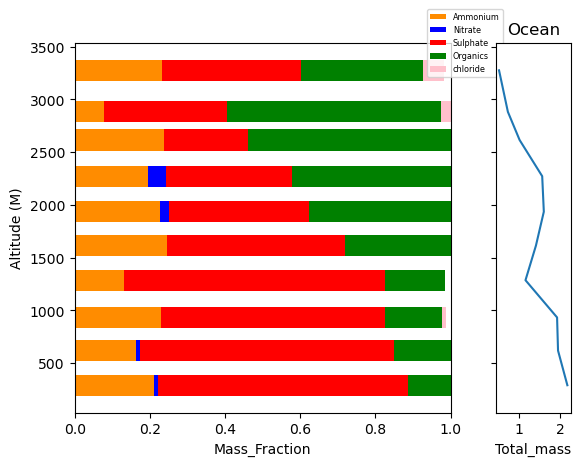

In [65]:
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left = ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left = ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "red", label = 'Sulphate')
ax[0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left = ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "green", label = 'Organics')
ax[0].barh(ocean_transport_plot['GPS_Altitude_THORNHILL'], ocean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left = ocean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+ocean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "pink", label = 'chloride')
ax[1].plot(ocean_transport_plot['AMS'], ocean_transport_plot['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (M)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('Ocean')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [66]:
# Concatenate the dataframes vertically (along rows)
North_America = pd.concat([DAY1000_subset_7, DAY1000_subset_7b, DAY1000_subset_17], axis=0)

# Reset the index of the merged dataframe
North_America.reset_index(drop=True, inplace=True)
North_America.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
count,67,67,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,2022-06-09 07:55:27.365671680,2022-06-09 07:55:28.365671424,32.231930,-65.009193,548.055485,0.534403,0.322741,0.026862,0.112945,0.003112,0.189284,0.110311,2.821119
min,2022-06-07 14:32:05.500000,2022-06-07 14:32:06.500000,32.170456,-65.065358,129.055000,0.240557,0.231022,-0.024861,-0.033708,-0.035168,-0.013000,-0.053719,1.006000
25%,2022-06-07 14:35:12,2022-06-07 14:35:13,32.204156,-65.035596,339.925000,0.528803,0.261916,0.015694,0.083443,-0.002753,0.077000,0.088829,1.776000
50%,2022-06-07 19:08:21.500000,2022-06-07 19:08:22.500000,32.234662,-65.004544,544.710000,0.549837,0.295521,0.024377,0.125171,0.003356,0.141000,0.117227,2.384000
75%,2022-06-07 19:11:12,2022-06-07 19:11:13,32.256013,-64.980855,761.390000,0.565264,0.351176,0.032443,0.155621,0.007978,0.296000,0.132756,3.947000
max,2022-06-17 16:24:41.500000,2022-06-17 16:24:42.500000,32.302729,-64.967740,976.435000,0.643388,0.656064,0.078296,0.297297,0.030267,0.372000,0.162281,4.444000
std,NaN,NaN,0.036262,0.029191,246.243019,0.070724,0.082415,0.020526,0.062798,0.012818,0.119523,0.039330,1.148324


In [67]:
# Concatenate the dataframes vertically (along rows)
North_America2 = pd.concat([DAY7_subset_3000, DAY7b_subset_3000, DAY17_subset_3000], axis=0)

# Reset the index of the merged dataframe
North_America2.reset_index(drop=True, inplace=True)
North_America2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
count,171,171,171.000000,171.000000,171.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,2022-06-09 13:56:08.766082304,2022-06-09 13:56:09.766081792,32.233552,-65.015680,2106.197515,0.578176,0.254393,0.010915,0.152079,0.003886,0.085500,0.100761,1.501717
min,2022-06-07 14:38:12,2022-06-07 14:38:13,32.162797,-65.062216,1003.240000,0.198009,0.085057,-0.104762,-0.518234,-0.074661,-0.049000,-0.087971,0.442000
25%,2022-06-07 14:44:39.249999872,2022-06-07 14:44:40.249999872,32.209850,-65.045612,1545.220000,0.465710,0.162365,-0.016935,0.057045,-0.013058,0.037000,0.052846,0.919000
50%,2022-06-07 19:15:57.500000,2022-06-07 19:15:58.500000,32.236294,-65.016038,2079.120000,0.590631,0.190601,0.017467,0.162592,0.007068,0.079000,0.115595,1.372000
75%,2022-06-07 19:21:51.500000,2022-06-07 19:21:52.500000,32.253525,-64.988630,2612.957500,0.676051,0.299385,0.033537,0.255196,0.017480,0.123000,0.132255,1.887500
max,2022-06-17 16:38:08.500000,2022-06-17 16:38:09.500000,32.300666,-64.960183,3459.850000,0.896848,0.761277,0.158824,0.537964,0.079365,0.239000,0.362069,3.410000
std,NaN,NaN,0.034251,0.030242,664.489037,0.164190,0.136675,0.053360,0.169684,0.029755,0.058974,0.060704,0.784339


In [68]:
North_America_transport = pd.concat([North_America, North_America2], axis=0)
North_America_transport.reset_index(drop=True, inplace=True)
North_America_transport
nbins = 10
bins = np.linspace(North_America_transport.GPS_Altitude_THORNHILL.min(), North_America_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
North_America_transport['Bins'] = pd.cut(North_America_transport['GPS_Altitude_THORNHILL'], bins)
North_America_transport_plot = North_America_transport.groupby('Bins').median()
North_America_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(129.055, 462.134]",2022-06-07 19:08:09.000000000,2022-06-07 19:08:10.000000000,32.242680,-64.990692,305.6750,0.562038,0.276398,0.020853,0.144943,0.004268,0.1410,0.123116,1.9180
"(462.134, 795.214]",2022-06-07 19:09:56.000000000,2022-06-07 19:09:57.000000000,32.234662,-65.006074,626.7200,0.543490,0.289977,0.026471,0.124398,0.002465,0.1150,0.117227,2.3840
"(795.214, 1128.294]",2022-06-07 19:11:26.000000000,2022-06-07 19:11:27.000000000,32.240078,-65.030907,936.2300,0.543490,0.395250,0.023097,0.132181,0.004106,0.1430,0.107681,3.0740
"(1128.294, 1461.373]",2022-06-07 19:13:16.249999872,2022-06-07 19:13:17.249999872,32.235862,-65.009517,1293.3200,0.540760,0.295778,0.015654,0.185172,0.011584,0.1320,0.118541,2.6015
"(1461.373, 1794.452]",2022-06-07 19:15:09.000000000,2022-06-07 19:15:10.000000000,32.244333,-65.028508,1635.5275,0.676051,0.161967,0.028736,0.125783,-0.004047,0.1235,0.107617,1.8275
"(1794.452, 2127.532]",2022-06-07 19:17:02.249999872,2022-06-07 19:17:03.249999872,32.227914,-64.989851,1965.8425,0.729317,0.171033,0.013545,0.077183,-0.005180,0.0790,0.081632,1.3120
"(2127.532, 2460.612]",2022-06-07 19:18:46.000000000,2022-06-07 19:18:47.000000000,32.211862,-65.021523,2295.2200,0.597895,0.255789,0.020134,0.181208,0.004785,0.0410,0.054146,0.9500
"(2460.612, 2793.691]",2022-06-07 19:20:16.500000000,2022-06-07 19:20:17.500000000,32.239553,-65.040110,2630.3350,0.568839,0.195762,0.028888,0.171790,0.011697,0.0790,0.126673,1.0280
"(2793.691, 3126.77]",2022-06-07 19:21:44.000000000,2022-06-07 19:21:45.000000000,32.218298,-65.003107,2951.4400,0.606838,0.176200,0.023669,0.181460,0.015078,0.1220,0.132178,1.5210


In [69]:
#sensitivity test'

# Count the number of values greater than or equal to 0.4
count = len(North_America_transport_plot[North_America_transport_plot['AMS'] >= 0.5])

# Print the count
print("Number of values >= 0.5:", count)

Number of values >= 0.5: 10


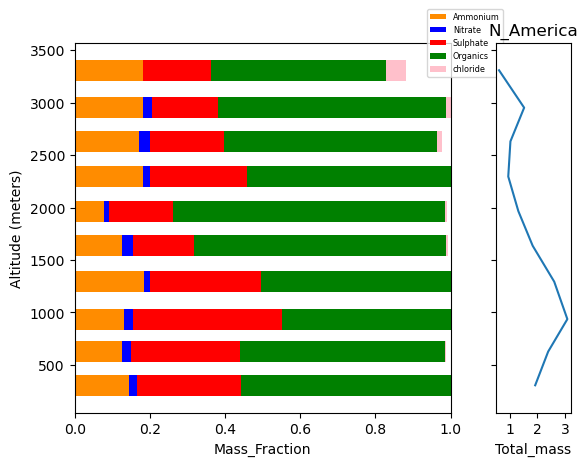

In [70]:
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "red", label = 'Sulphate')
ax[0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "green", label = 'Organics')
ax[0].barh(North_America_transport_plot['GPS_Altitude_THORNHILL'], North_America_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left = North_America_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+North_America_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "pink", label = 'chloride')
ax[1].plot(North_America_transport_plot['AMS'], North_America_transport_plot['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('N_America')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [71]:
# Concatenate the dataframes vertically (along rows)
Caribbean = pd.concat([DAY1000_subset_3, DAY1000_subset_8, DAY1000_subset_10, DAY1000_subset_10b, DAY1000_subset_11, DAY1000_subset_11b], axis=0)

# Reset the index of the merged dataframe
Caribbean.reset_index(drop=True, inplace=True)
Caribbean.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
count,123,123,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,2022-06-09 21:33:47.813008384,2022-06-09 21:33:48.813008128,32.134984,-65.354587,537.627256,0.225815,0.606741,0.008311,0.158536,0.002126,0.036374,0.033084,1.861931
min,2022-06-03 13:34:13,2022-06-03 13:34:14,31.032251,-67.647716,117.685000,-0.064378,0.473664,-0.041004,-0.087434,-0.022514,-0.101000,-1.944444,1.013000
25%,2022-06-08 20:33:55.500000,2022-06-08 20:33:56.500000,31.290581,-65.823090,332.080000,0.152252,0.557450,-0.008982,0.114253,-0.004858,-0.001500,-0.016097,1.565000
50%,2022-06-10 19:36:27,2022-06-10 19:36:28,32.243474,-65.035588,538.452500,0.206801,0.622156,0.013849,0.174373,0.002242,0.028000,0.067308,1.733000
75%,2022-06-11 15:28:22.249999872,2022-06-11 15:28:23.249999872,32.297956,-64.982777,745.576250,0.301748,0.651902,0.018752,0.222117,0.007506,0.066000,0.128463,2.172000
max,2022-06-11 20:10:12.500000,2022-06-11 20:10:13.500000,34.268631,-64.425458,961.977500,0.434934,0.952790,0.102665,0.316508,0.050052,0.168000,0.961905,2.933000
std,NaN,NaN,0.853349,0.829162,242.683840,0.111901,0.078193,0.021519,0.090841,0.010696,0.051600,0.309507,0.449465


In [72]:
# Concatenate the dataframes vertically (along rows)
Caribbean2 = pd.concat([DAY3_subset_3000, DAY8_subset_3000, DAY10_subset_3000, DAY10b_subset_3000, DAY11_subset_3000, DAY11b_subset_3000, DAY13_subset_3000, DAY1000_subset_13b], axis=0)

# Reset the index of the merged dataframe
Caribbean2.reset_index(drop=True, inplace=True)
Caribbean2.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
count,431,431,431.000000,431.000000,431.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,2022-06-10 11:55:43.510440960,2022-06-10 11:55:44.510440960,32.149584,-65.245658,2137.245278,0.337756,0.512994,0.006883,0.140853,0.005228,0.035315,0.444329,1.043810
min,2022-06-03 13:31:11,2022-06-03 13:31:12,31.010262,-67.726647,119.627500,-0.687764,0.162651,-0.147849,-0.906977,-0.147696,-0.133000,-23.250000,0.227000
25%,2022-06-08 20:43:57.750000128,2022-06-08 20:43:58.750000128,31.821700,-65.095180,1524.165000,0.212021,0.396119,-0.022425,0.085529,-0.008147,-0.010500,-0.034014,0.590000
50%,2022-06-10 20:10:13,2022-06-10 20:10:14,32.237933,-65.027314,2152.100000,0.335785,0.501873,0.008565,0.146986,0.003597,0.022000,0.097259,0.919000
75%,2022-06-11 20:15:05.500000,2022-06-11 20:15:06.500000,32.280037,-64.979268,2784.287500,0.464619,0.591865,0.032150,0.227451,0.019919,0.083750,0.166320,1.294750
max,2022-06-13 19:50:47,2022-06-13 19:50:48,34.313846,-64.374791,3449.025000,1.186131,1.427313,0.291139,0.869198,0.137045,0.213000,133.000000,3.293000
std,NaN,NaN,0.690047,0.661137,769.505778,0.226466,0.187279,0.055484,0.188862,0.035246,0.063473,9.286854,0.609579


In [73]:
Caribbean_transport = pd.concat([Caribbean, Caribbean2], axis=0)
Caribbean_transport.reset_index(drop=True, inplace=True)
nbins = 10
bins = np.linspace(Caribbean_transport.GPS_Altitude_THORNHILL.min(), Caribbean_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Caribbean_transport['Bins'] = pd.cut(Caribbean_transport['GPS_Altitude_THORNHILL'], bins)
Caribbean_transport_plot = Caribbean_transport.groupby('Bins').median()
Caribbean_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(117.685, 450.819]",2022-06-10 20:21:43.000000000,2022-06-10 20:21:44.000000000,32.246596,-65.015215,278.0025,0.182907,0.651902,0.015900,0.169811,-0.001732,0.0140,0.047788,1.761
"(450.819, 783.953]",2022-06-10 20:19:04.500000000,2022-06-10 20:19:05.500000000,32.242698,-65.021344,613.4300,0.206801,0.598452,-0.008982,0.184431,0.004151,0.0165,0.041916,1.670
"(783.953, 1117.087]",2022-06-10 19:57:27.249999872,2022-06-10 19:57:28.249999872,32.254331,-65.070602,928.2275,0.229083,0.550673,0.009414,0.219028,0.003509,0.0510,0.112591,1.913
"(1117.087, 1450.221]",2022-06-10 20:14:49.000000000,2022-06-10 20:14:50.000000000,32.237246,-65.039284,1287.0600,0.271617,0.528279,-0.001428,0.195437,0.001639,0.0180,0.062284,1.233
"(1450.221, 1783.355]",2022-06-10 20:13:58.249999872,2022-06-10 20:13:59.249999872,32.216352,-65.063048,1620.6400,0.245724,0.522685,0.014985,0.166122,0.008297,0.0350,0.137168,1.274
"(1783.355, 2116.489]",2022-06-10 20:10:23.000000000,2022-06-10 20:10:24.000000000,32.226895,-65.017895,1955.2050,0.368695,0.508678,0.016641,0.146986,0.002098,0.0430,0.128878,1.003
"(2116.489, 2449.623]",2022-06-10 20:09:35.500000000,2022-06-10 20:09:36.500000000,32.262926,-65.036126,2281.9400,0.381313,0.442986,0.022549,0.129278,0.006853,0.0350,0.100559,0.988
"(2449.623, 2782.757]",2022-06-10 20:05:40.000000000,2022-06-10 20:05:41.000000000,32.228040,-65.025249,2622.3500,0.459147,0.396119,0.002797,0.122845,0.008738,0.0210,0.068627,0.927
"(2782.757, 3115.891]",2022-06-10 20:01:22.000000000,2022-06-10 20:01:23.000000000,32.250566,-65.020349,2959.4850,0.430250,0.402655,0.011817,0.125884,0.002660,0.0300,0.144663,0.639


In [74]:
#sensitivity test'

# Count the number of values greater than or equal to 0.4
count = len(Caribbean_transport_plot[Caribbean_transport_plot['AMS'] >= 0.5])

# Print the count
print("Number of values >= 0.5:", count)

Number of values >= 0.5: 9


In [75]:
# Assuming you have a DataFrame named 'data' with a column named 'column_name'

# Filter the data using the condition >= 0.4
filtered_caribbean_data = Caribbean_transport_plot[Caribbean_transport_plot['AMS'] >= 0.5]

# Print the filtered data
filtered_caribbean_data



,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(117.685, 450.819]",2022-06-10 20:21:43.000000000,2022-06-10 20:21:44.000000000,32.246596,-65.015215,278.0025,0.182907,0.651902,0.015900,0.169811,-0.001732,0.0140,0.047788,1.761
"(450.819, 783.953]",2022-06-10 20:19:04.500000000,2022-06-10 20:19:05.500000000,32.242698,-65.021344,613.4300,0.206801,0.598452,-0.008982,0.184431,0.004151,0.0165,0.041916,1.670
"(783.953, 1117.087]",2022-06-10 19:57:27.249999872,2022-06-10 19:57:28.249999872,32.254331,-65.070602,928.2275,0.229083,0.550673,0.009414,0.219028,0.003509,0.0510,0.112591,1.913
"(1117.087, 1450.221]",2022-06-10 20:14:49.000000000,2022-06-10 20:14:50.000000000,32.237246,-65.039284,1287.0600,0.271617,0.528279,-0.001428,0.195437,0.001639,0.0180,0.062284,1.233
"(1450.221, 1783.355]",2022-06-10 20:13:58.249999872,2022-06-10 20:13:59.249999872,32.216352,-65.063048,1620.6400,0.245724,0.522685,0.014985,0.166122,0.008297,0.0350,0.137168,1.274
"(1783.355, 2116.489]",2022-06-10 20:10:23.000000000,2022-06-10 20:10:24.000000000,32.226895,-65.017895,1955.2050,0.368695,0.508678,0.016641,0.146986,0.002098,0.0430,0.128878,1.003
"(2116.489, 2449.623]",2022-06-10 20:09:35.500000000,2022-06-10 20:09:36.500000000,32.262926,-65.036126,2281.9400,0.381313,0.442986,0.022549,0.129278,0.006853,0.0350,0.100559,0.988
"(2449.623, 2782.757]",2022-06-10 20:05:40.000000000,2022-06-10 20:05:41.000000000,32.228040,-65.025249,2622.3500,0.459147,0.396119,0.002797,0.122845,0.008738,0.0210,0.068627,0.927
"(2782.757, 3115.891]",2022-06-10 20:01:22.000000000,2022-06-10 20:01:23.000000000,32.250566,-65.020349,2959.4850,0.430250,0.402655,0.011817,0.125884,0.002660,0.0300,0.144663,0.639


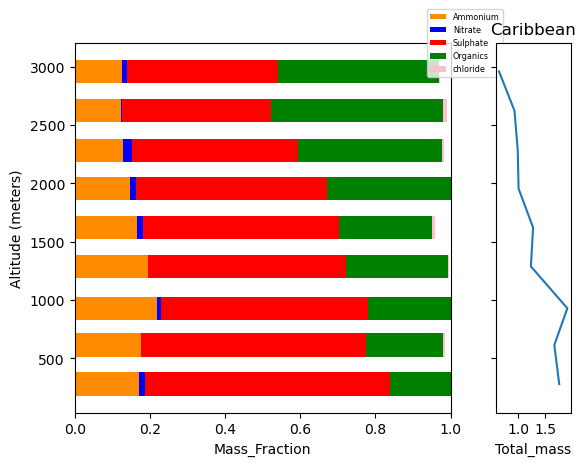

In [76]:
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(filtered_caribbean_data['GPS_Altitude_THORNHILL'], filtered_caribbean_data['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(filtered_caribbean_data['GPS_Altitude_THORNHILL'], filtered_caribbean_data['NO3_Ave_IsoK_STP_ZIEMBA'], left = filtered_caribbean_data['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(filtered_caribbean_data['GPS_Altitude_THORNHILL'], filtered_caribbean_data['SO4_Ave_IsoK_STP_ZIEMBA'], left = filtered_caribbean_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_caribbean_data['NO3_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "red", label = 'Sulphate')
ax[0].barh(filtered_caribbean_data['GPS_Altitude_THORNHILL'], filtered_caribbean_data['Org_Ave_IsoK_STP_ZIEMBA'], left = filtered_caribbean_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_caribbean_data['NO3_Ave_IsoK_STP_ZIEMBA']+filtered_caribbean_data['SO4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "green", label = 'Organics')
ax[0].barh(filtered_caribbean_data['GPS_Altitude_THORNHILL'], filtered_caribbean_data['Chl_Ave_IsoK_STP_ZIEMBA'], left = filtered_caribbean_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_caribbean_data['NO3_Ave_IsoK_STP_ZIEMBA']+filtered_caribbean_data['SO4_Ave_IsoK_STP_ZIEMBA']+filtered_caribbean_data['Org_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "pink", label = 'chloride')
ax[1].plot(filtered_caribbean_data['AMS'], filtered_caribbean_data['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('Caribbean')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

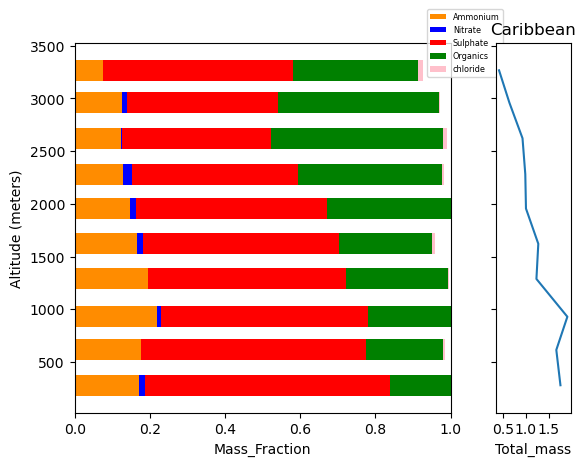

In [77]:
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left = Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left = Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "red", label = 'Sulphate')
ax[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left = Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "green", label = 'Organics')
ax[0].barh(Caribbean_transport_plot['GPS_Altitude_THORNHILL'], Caribbean_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left = Caribbean_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+Caribbean_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "pink", label = 'chloride')
ax[1].plot(Caribbean_transport_plot['AMS'], Caribbean_transport_plot['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('Caribbean')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [78]:
Africa = pd.concat([DAY1000_subset_13, DAY1000_subset_13b, DAY1000_subset_14])
# Reset the index of the merged dataframe
Africa.reset_index(drop=True, inplace=True)
Africa.describe()

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
count,48,48,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,2022-06-13 21:57:17.500000,2022-06-13 21:57:18.500000,31.918169,-64.885110,541.119323,0.178992,0.726554,-0.005474,0.090921,0.009007,-0.015792,-1.493809,0.998500
min,2022-06-13 14:30:32,2022-06-13 14:30:33,30.634387,-65.097842,118.025000,-0.186014,0.524390,-0.147849,-0.381720,-0.041593,-0.093000,-23.250000,0.353000
25%,2022-06-13 14:33:19.249999872,2022-06-13 14:33:20.249999872,32.200100,-65.034796,335.403750,0.111662,0.600000,-0.032654,0.031596,-0.013986,-0.047000,-0.262295,0.715000
50%,2022-06-13 19:47:40.500000,2022-06-13 19:47:41.500000,32.234695,-64.989256,547.037500,0.188290,0.657400,0.005543,0.139576,0.001449,-0.023000,-0.041176,0.903000
75%,2022-06-13 19:50:19,2022-06-13 19:50:20,32.266972,-64.933572,748.401250,0.272566,0.862069,0.035115,0.186014,0.033333,0.012750,0.105172,1.307750
max,2022-06-14 16:07:10.500000,2022-06-14 16:07:11.500000,32.287315,-64.387056,954.452500,0.491389,1.124646,0.084582,0.366972,0.077957,0.061000,0.445545,1.804000
std,NaN,NaN,0.649694,0.245436,248.144449,0.168706,0.176672,0.062322,0.169679,0.030566,0.041865,5.683188,0.396599


In [79]:
Africa_transport = pd.concat([Africa, DAY14_subset_3000], axis=0)
Africa_transport.reset_index(drop=True, inplace=True)
nbins = 10
bins = np.linspace(Africa_transport.GPS_Altitude_THORNHILL.min(), Africa_transport.GPS_Altitude_THORNHILL.max(), nbins+1)
Africa_transport['Bins'] = pd.cut(Africa_transport['GPS_Altitude_THORNHILL'], bins)
Africa_transport_plot = Africa_transport.groupby('Bins').median()
Africa_transport_plot

,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(118.025, 439.969]",2022-06-13 19:46:50.000000000,2022-06-13 19:46:51.000000000,32.245850,-64.962152,292.31000,0.188290,0.656180,0.020885,0.122056,0.000756,-0.034,-0.118056,1.258
"(439.969, 761.914]",2022-06-13 19:48:37.000000000,2022-06-13 19:48:38.000000000,32.251852,-64.996778,602.36000,0.272566,0.862069,-0.011331,0.122056,0.010495,-0.004,-0.018100,0.715
"(761.914, 1083.858]",2022-06-13 19:50:07.000000000,2022-06-13 19:50:08.000000000,32.201005,-64.964015,876.52125,0.159061,0.572905,-0.006091,0.201245,0.013480,0.012,0.039229,0.872
"(1083.858, 1405.803]",2022-06-14 16:07:48.500000000,2022-06-14 16:07:49.500000000,30.640051,-64.403570,1247.74000,0.551591,0.360656,-0.000964,0.073288,0.015429,0.050,0.087413,1.037
"(1405.803, 1727.748]",2022-06-14 16:08:22.249999872,2022-06-14 16:08:23.249999872,30.655318,-64.434507,1539.64500,0.685658,0.583497,-0.031434,-0.237721,0.000000,0.013,0.037249,0.509
"(1727.748, 2049.692]",2022-06-14 16:09:00.750000128,2022-06-14 16:09:01.750000128,30.690437,-64.416487,1872.58000,0.706109,0.308489,-0.024901,-0.030814,0.041117,0.001,-0.017777,0.579
"(2049.692, 2371.636]",2022-06-14 16:09:38.750000128,2022-06-14 16:09:39.750000128,30.678593,-64.373345,2206.24250,2.682927,-2.219512,0.756098,0.390244,-0.609756,-0.004,0.036364,-0.041
"(2371.636, 2693.581]",2022-06-14 16:10:18.000000000,2022-06-14 16:10:19.000000000,30.641662,-64.383021,2543.56500,-0.666667,-5.166667,-2.600000,9.433333,-0.000000,-0.019,-0.950000,-0.030
"(2693.581, 3015.525]",2022-06-14 16:10:59.500000000,2022-06-14 16:11:00.500000000,30.654174,-64.427142,2879.46250,0.349672,0.215278,0.059367,0.324235,0.051448,-0.017,-0.061775,0.781


In [80]:
#sensitivity test'

# Count the number of values greater than or equal to 0.4
count = len(Africa_transport_plot[Africa_transport_plot['AMS'] >= 0.5])

# Print the count
print("Number of values >= 0.5:", count)

Number of values >= 0.5: 7


In [81]:
# Filter the data using the condition >= 0.4
filtered_Africa_data = Africa_transport_plot[Africa_transport_plot['AMS'] >= 0.5]

# Print the filtered data
filtered_Africa_data



,Time_Start,Time_Stop,Latitude_THORNHILL,Longitude_THORNHILL,GPS_Altitude_THORNHILL,Org_Ave_IsoK_STP_ZIEMBA,SO4_Ave_IsoK_STP_ZIEMBA,NO3_Ave_IsoK_STP_ZIEMBA,NH4_Ave_IsoK_STP_ZIEMBA,Chl_Ave_IsoK_STP_ZIEMBA,mz44_Ave_IsoK_STP_ZIEMBA,mz44,AMS
Bins,,,,,,,,,,,,,
"(118.025, 439.969]",2022-06-13 19:46:50.000000000,2022-06-13 19:46:51.000000000,32.245850,-64.962152,292.31000,0.188290,0.656180,0.020885,0.122056,0.000756,-0.034,-0.118056,1.258
"(439.969, 761.914]",2022-06-13 19:48:37.000000000,2022-06-13 19:48:38.000000000,32.251852,-64.996778,602.36000,0.272566,0.862069,-0.011331,0.122056,0.010495,-0.004,-0.018100,0.715
"(761.914, 1083.858]",2022-06-13 19:50:07.000000000,2022-06-13 19:50:08.000000000,32.201005,-64.964015,876.52125,0.159061,0.572905,-0.006091,0.201245,0.013480,0.012,0.039229,0.872
"(1083.858, 1405.803]",2022-06-14 16:07:48.500000000,2022-06-14 16:07:49.500000000,30.640051,-64.403570,1247.74000,0.551591,0.360656,-0.000964,0.073288,0.015429,0.050,0.087413,1.037
"(1405.803, 1727.748]",2022-06-14 16:08:22.249999872,2022-06-14 16:08:23.249999872,30.655318,-64.434507,1539.64500,0.685658,0.583497,-0.031434,-0.237721,0.000000,0.013,0.037249,0.509
"(1727.748, 2049.692]",2022-06-14 16:09:00.750000128,2022-06-14 16:09:01.750000128,30.690437,-64.416487,1872.58000,0.706109,0.308489,-0.024901,-0.030814,0.041117,0.001,-0.017777,0.579
"(2693.581, 3015.525]",2022-06-14 16:10:59.500000000,2022-06-14 16:11:00.500000000,30.654174,-64.427142,2879.46250,0.349672,0.215278,0.059367,0.324235,0.051448,-0.017,-0.061775,0.781


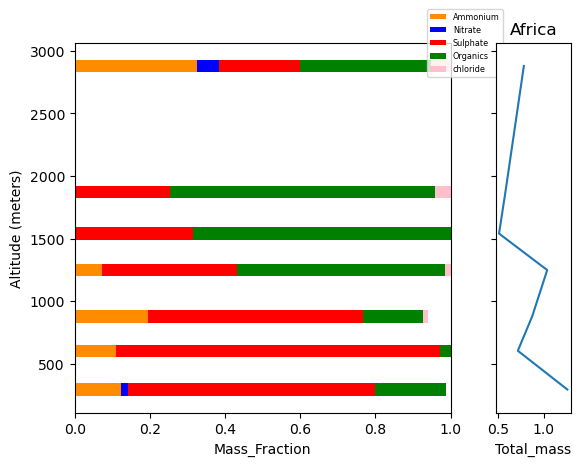

In [82]:
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA'], height = 100, color = "darkorange", label = 'Ammonium')
ax[0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA'], left = filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA'], height = 100, color = "blue", label = 'Nitrate')
ax[0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA'], left = filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA'], height = 100, color = "red", label = 'Sulphate')
ax[0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['Org_Ave_IsoK_STP_ZIEMBA'], left = filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA'], height = 100, color = "green", label = 'Organics')
ax[0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['Chl_Ave_IsoK_STP_ZIEMBA'], left = filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['Org_Ave_IsoK_STP_ZIEMBA'], height = 100, color = "pink", label = 'chloride')
ax[1].plot(filtered_Africa_data['AMS'], filtered_Africa_data['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('Africa')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

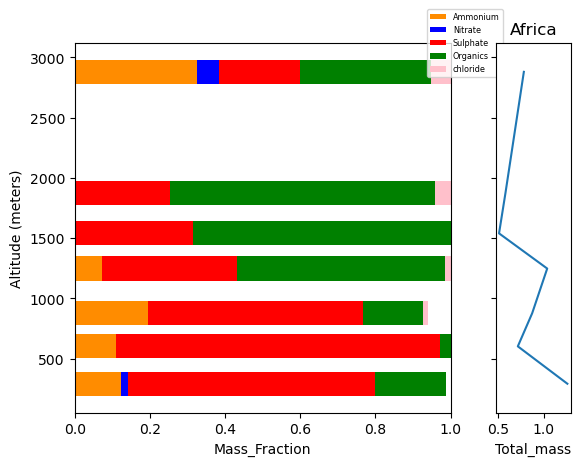

In [83]:
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA'], left = filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA'], left = filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "red", label = 'Sulphate')
ax[0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['Org_Ave_IsoK_STP_ZIEMBA'], left = filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "green", label = 'Organics')
ax[0].barh(filtered_Africa_data['GPS_Altitude_THORNHILL'], filtered_Africa_data['Chl_Ave_IsoK_STP_ZIEMBA'], left = filtered_Africa_data['NH4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['NO3_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['SO4_Ave_IsoK_STP_ZIEMBA']+filtered_Africa_data['Org_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "pink", label = 'chloride')
ax[1].plot(filtered_Africa_data['AMS'], filtered_Africa_data['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('Africa')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

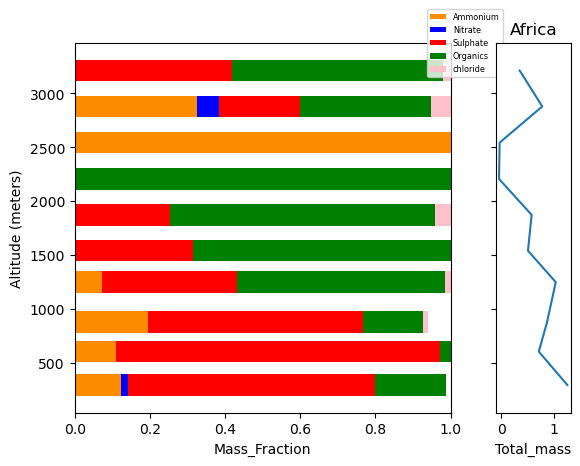

In [84]:
fig,ax = plt.subplots(1,2, width_ratios=[20, 4], sharey = "all")
ax[0].barh(Africa_transport_plot['GPS_Altitude_THORNHILL'], Africa_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "darkorange", label = 'Ammonium')
ax[0].barh(Africa_transport_plot['GPS_Altitude_THORNHILL'], Africa_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], left = Africa_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "blue", label = 'Nitrate')
ax[0].barh(Africa_transport_plot['GPS_Altitude_THORNHILL'], Africa_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], left = Africa_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Africa_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "red", label = 'Sulphate')
ax[0].barh(Africa_transport_plot['GPS_Altitude_THORNHILL'], Africa_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], left = Africa_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Africa_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+Africa_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "green", label = 'Organics')
ax[0].barh(Africa_transport_plot['GPS_Altitude_THORNHILL'], Africa_transport_plot['Chl_Ave_IsoK_STP_ZIEMBA'], left = Africa_transport_plot['NH4_Ave_IsoK_STP_ZIEMBA']+Africa_transport_plot['NO3_Ave_IsoK_STP_ZIEMBA']+Africa_transport_plot['SO4_Ave_IsoK_STP_ZIEMBA']+Africa_transport_plot['Org_Ave_IsoK_STP_ZIEMBA'], height = 200, color = "pink", label = 'chloride')
ax[1].plot(Africa_transport_plot['AMS'], Africa_transport_plot['GPS_Altitude_THORNHILL'], label = 'Total_mass')

ax[0].set_ylabel('Altitude (meters)')
ax[0].set_xlabel('Mass_Fraction')
ax[0].set_xlim(0,1)
ax[1].set_xlabel('Total_mass')
plt.title('Africa')

ax[0].legend(bbox_to_anchor=(1.15, 1), loc = 'right', fontsize='xx-small')

In [85]:
# Concatenate the dataframes vertically (along rows)
merged_df = pd.concat([Caribbean.describe(), Caribbean2.describe(), North_America.describe(), North_America2.describe(), ocean.describe(), ocean2.describe(), Africa.describe(), DAY14_subset_3000.describe()], axis=0)

# Reset the index of the merged dataframe
merged_df.reset_index(drop=False, inplace=True)

# Display the merged dataframe
merged_df
merged_df.to_csv('C:/Users/taiwoajayi/OneDrive - University of Arizona/python/chemistry_mass_description.csv')

In [86]:
# Assuming you have a DataFrame named 'data' with a column named 'column_name'

# Filter the data using the condition >= 0.4
filtered_data = data[data['column_name'] >= 0.4]

# Print the filtered data
print(filtered_data)


NameError: name 'data' is not defined